### Load data and choose rois

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cortex
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import h5py
import os
import nibabel as nib
from collections import defaultdict 
import statsmodels.api as sm

First, train the decoders with simulated data.

In [ ]:
zs = lambda v: (v-v.mean(0))/v.std(0)

def make_pink_noise(nT, beta=1):
    # beta: power law exponent
    freqs = np.fft.rfftfreq(nT)
    freqs[0] = 1
    spectrum = np.random.randn(len(freqs)) + 1j * np.random.randn(len(freqs))
    spectrum /= freqs ** (beta/2)  # power spectrum follos 1/f^beta, amplitude spectrum follows this
    pink_noise = np.fft.irfft(spectrum, n=nT)
    return pink_noise / np.std(pink_noise)

def make_correlated_arp(ar_coeff, nT, n_series, corr=1, noise_std=1, measurement_noise_std=1):
    shared_signal_std = noise_std * np.sqrt(corr)  # shared variability across runs
    trial_noise_std = noise_std * np.sqrt(1 - corr) # independent variability
    
    shared_signal = np.random.randn(nT) * shared_signal_std
    trial_noise = np.random.randn(n_series, nT) * trial_noise_std 

    # Generate measurement noise that is NOT part of the AR process (white or pink)
    # white_noise = np.random.randn(n_series,nT) * measurement_noise_std
    pink_noise = np.array([make_pink_noise(nT) for _ in range(n_series)]) * measurement_noise_std

    time_series = np.zeros((n_series, nT))
    time_series[:,0] = shared_signal[0] + trial_noise[:,0] # first time step

    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + shared_signal[t] + trial_noise[:, t]


    # noisy_time_series = time_series + white_noise
    noisy_time_series = time_series + pink_noise

    
    return noisy_time_series

# this fit AR to noise in each trial, and then get the average of beta estimate 
def fit_ind_noise_to_ar1(response_trials, nRuns):
    avg_resp = zs(np.mean(response_trials, axis=0))
    noise_lb = response_trials - avg_resp 
    noise_ub = np.zeros_like(noise_lb)
    est_beta_lb = []
    est_beta_ub = []
    for i in range(nRuns):
        ar1_model_lb = sm.tsa.AutoReg(zs(noise_lb[i]), lags=1).fit()
        est_beta_lb.append(ar1_model_lb.params[1])
        jackknife_mean = np.mean(np.delete(response_trials, i, axis=0), axis=0)
        noise_ub[i] = response_trials[i,:] - jackknife_mean
        ar1_model_ub = sm.tsa.AutoReg(zs(noise_ub[i]), lags=1).fit()
        est_beta_ub.append(ar1_model_ub.params[1])

    mean_beta_lb = np.mean(est_beta_lb)
    mean_beta_ub = np.mean(est_beta_ub)

    return mean_beta_ub

def estimate_snr(response_trials):
    # response_trials should be ROI averaged data, with the shape (nRuns x nTimepoints)
    signal = np.mean(response_trials, axis=0)
    signal_var = np.var(signal, ddof=1)
    noise = response_trials - signal
    noise_var = np.var(noise, ddof=1) 
    snr = signal_var/(signal_var + noise_var) 
    return snr


In [109]:
nLoops = 500
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.arange(0,1,0.1)
corrs = np.arange(0,1,0.1)
sim_data = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
est_beta_lb = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
est_beta_ub = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

run_avg_est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        for corr in range(len(corrs)):
            sim_data[loop, coeff, corr, :, :] = make_correlated_arp(real_ar_coeff[coeff], nT, n_series=nRuns, corr=corrs[corr]) 
            est_beta_ub[loop, coeff, corr] = fit_ind_noise_to_ar1(sim_data[loop, coeff, corr, :, :], nRuns)
            
            # Average across 10 runs and then fit the AR(1) model
            avg_series = np.mean(sim_data[loop, coeff, corr, :, :], axis=0)
            zs_avg_series = zs(avg_series)
            ar1_model = sm.tsa.AutoReg(zs_avg_series, lags=1).fit()
            run_avg_est_ar_coeff[loop,coeff, corr] = ar1_model.params[1]

Visualize the fake data and the estimated alpha and beta values:

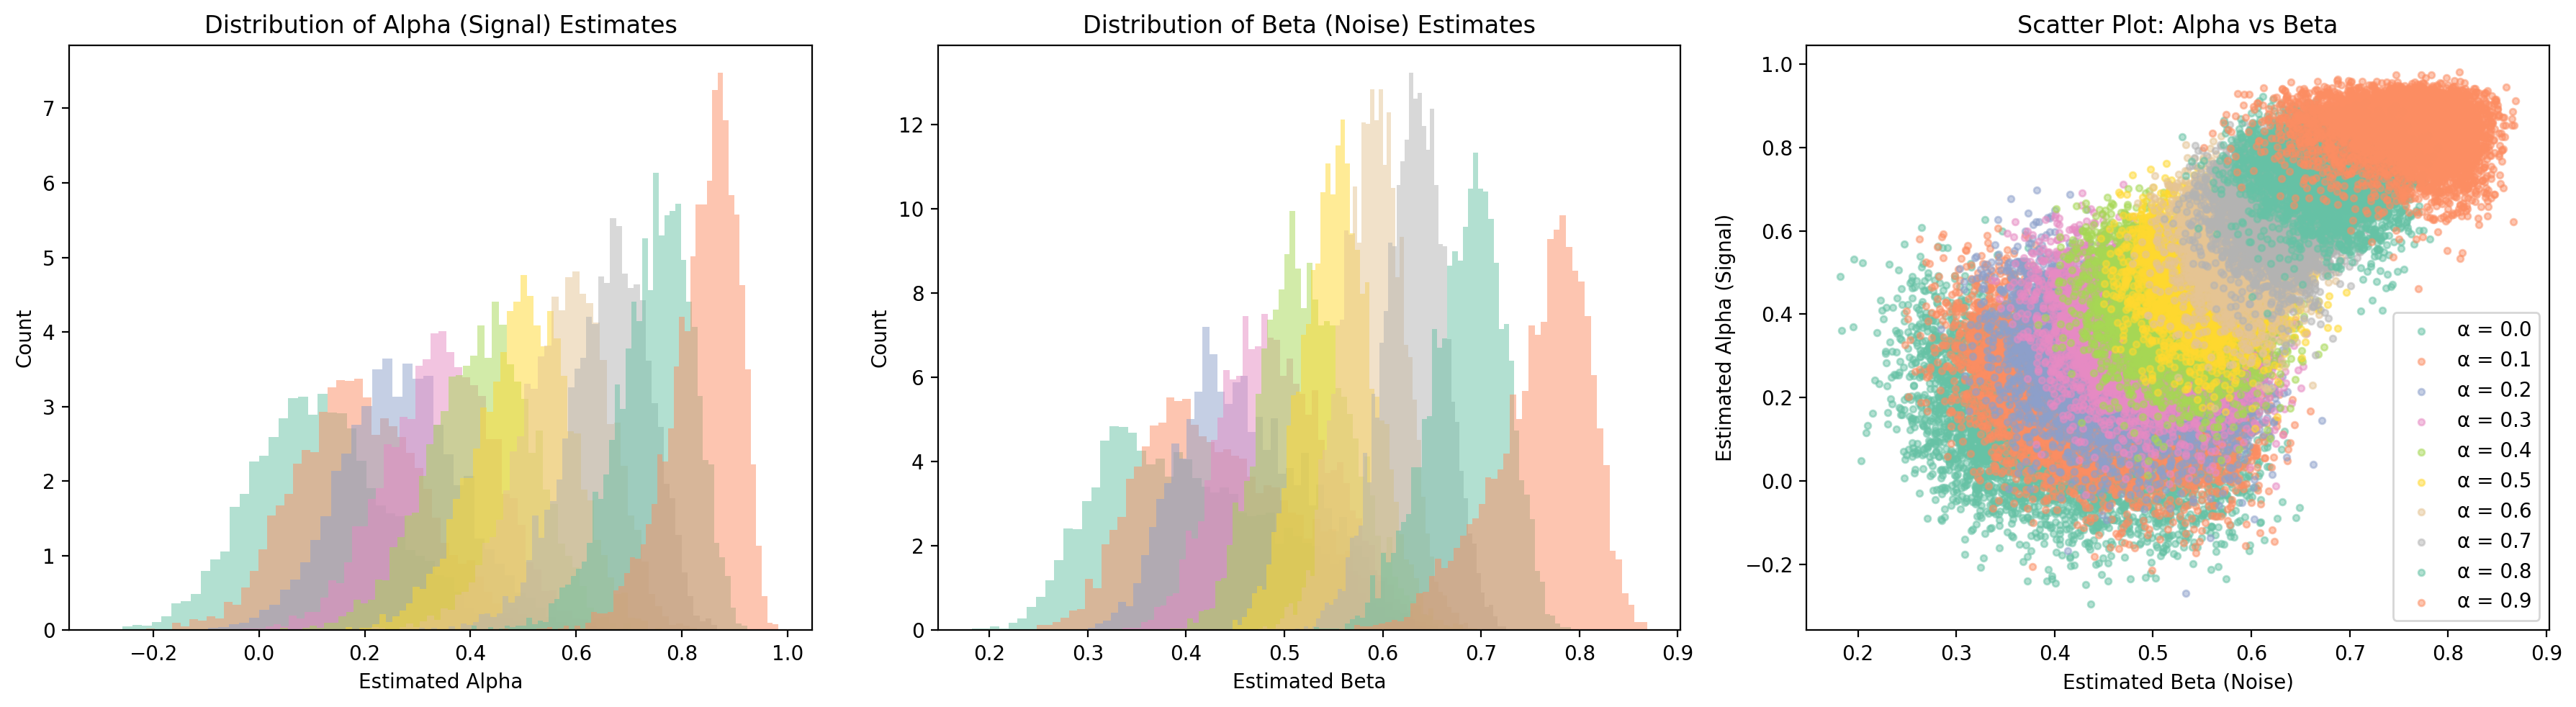

In [153]:
import seaborn as sns
colors = sns.color_palette("Set2", n_colors=len(real_ar_coeff))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, alpha in enumerate(real_ar_coeff):
    # 1. Histogram of alpha estimates
    est_alpha_flat = run_avg_est_ar_coeff[:, i, :].flatten()
    axes[0].hist(est_alpha_flat, bins=50, alpha=0.5, color=colors[i], density=True)
    axes[0].set_title("Distribution of Alpha (Signal) Estimates")
    axes[0].set_xlabel("Estimated Alpha")
    axes[0].set_ylabel("Count")

    # 2. Histogram of beta estimates
    est_beta_flat = est_beta_ub[:,i,:].flatten()
    axes[1].hist(est_beta_flat, bins=50, alpha=0.5, color=colors[i], density=True)
    axes[1].set_title("Distribution of Beta (Noise) Estimates")
    axes[1].set_xlabel("Estimated Beta")
    axes[1].set_ylabel("Count")

    # 3. Scatter plot of alpha vs beta with true alpha as color
    axes[2].scatter(est_beta_flat, est_alpha_flat, color=colors[i], s=10, label=f"α = {alpha:.1f}", alpha=0.5)
    axes[2].set_title("Scatter Plot: Alpha vs Beta")
    axes[2].set_xlabel("Estimated Beta (Noise)")
    axes[2].set_ylabel("Estimated Alpha (Signal)")
plt.legend()
plt.tight_layout()
plt.show()


Dealing with SNR:

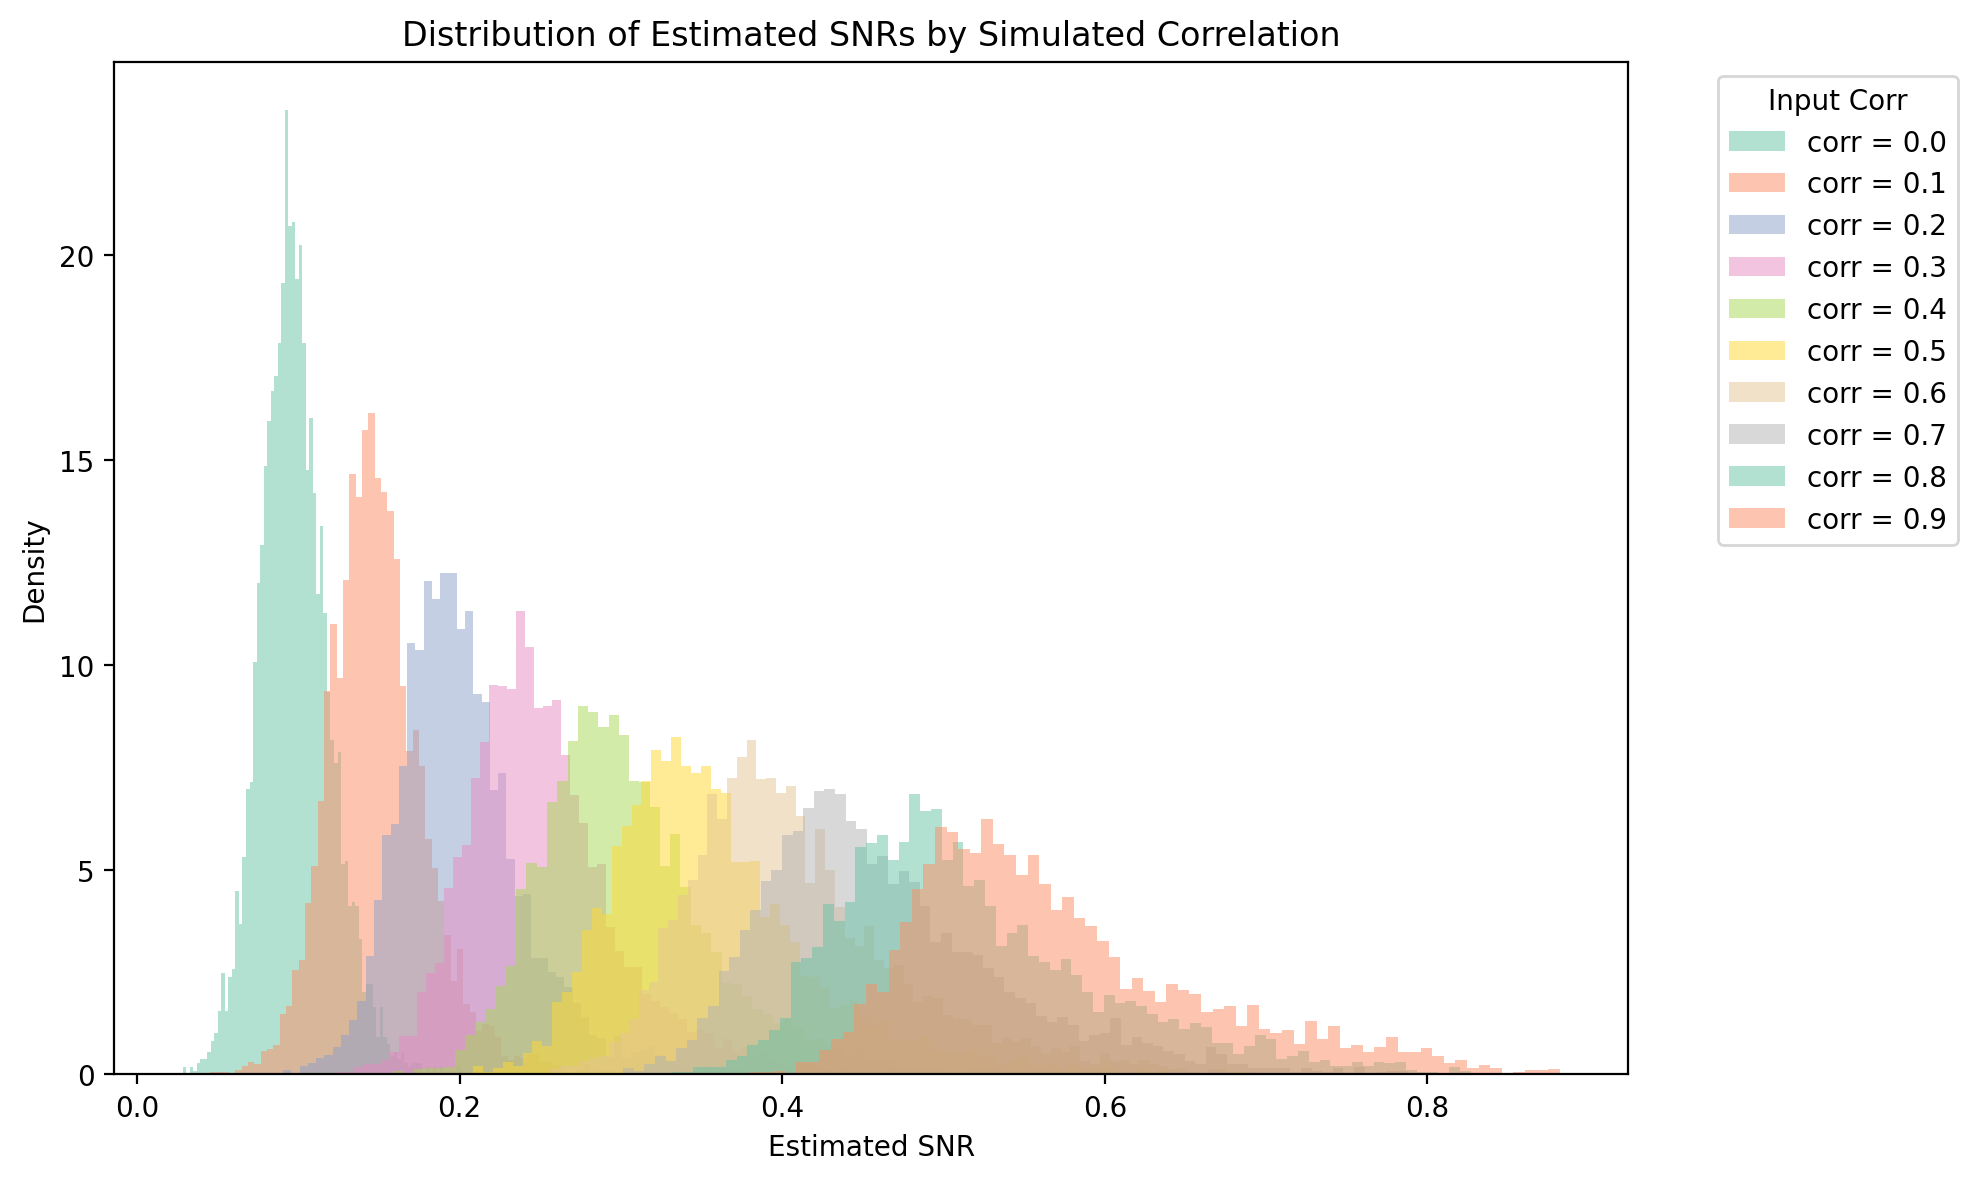

In [222]:
nLoops = 500
# First visualize the distribution of SNRs
# snr_by_corr = [[] for _ in range(len(corrs))]
snr_by_corr = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        for corr in range(len(corrs)):
            sim_snr = estimate_snr(sim_data[loop, coeff, corr, :, :])
            # snr_by_corr[corr].append(sim_snr)
            snr_by_corr[loop,coeff,corr] = sim_snr


# Plot SNR histograms by correlation level
colors = sns.color_palette("Set2", n_colors=len(corrs))
plt.figure(figsize=(10, 6))

for corr in range(len(corrs)):
    # plt.hist(snr_by_corr[corr], bins=80, alpha=0.5, color=colors[corr], label=f"corr = {corrs[corr]:.1f}", density=True)
    plt.hist(snr_by_corr[:,:,corr].flatten(), bins=80, alpha=0.5, color=colors[corr], label=f"corr = {corrs[corr]:.1f}", density=True)

plt.title("Distribution of Estimated SNRs by Simulated Correlation")
plt.xlabel("Estimated SNR")
plt.ylabel("Density")
plt.legend(title="Input Corr", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# This section is to compare 'corr' values used in simulation with other measures of SNR 
sim = np.zeros((len(corrs), nRuns, nT))
pearson_corr = np.zeros((len(corrs), nRuns, nRuns))
for corr in range(len(corrs)):
    sim[corr,:,:] = make_correlated_arp(0.5, nT, n_series=nRuns, corr=corrs[corr])

    # compute pairwise correlation 
    pearson_corr[corr,:,:] = np.corrcoef(sim[corr,:,:])
    mean_pearson_corr = np.mean(pearson_corr[corr,:,:])
    # print(mean_pearson_corr)

    # compute SNR (pack this into a function)
    signal = np.mean(sim[corr,:,:], axis=0)
    signal_var = np.var(signal, ddof=1)
    noise = sim[corr,:,:] - signal
    noise_var = np.var(noise, ddof=1) 
    snr = signal_var/(signal_var + noise_var) 
    print(snr)

# Conclusion: use SNR to train the blended model and calculate SNR the same way for real data

0.08660834802287343
0.1270703509365765
0.13579453523353033
0.2572576515103727
0.2739888043476294
0.3574131218208562
0.418281827320144
0.41118368421308327
0.5406867572665766
0.5432426383720517


Visualize the alpha (signal) and beta (noise) estimates at different SNR levels.

/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_17568/1421725012.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend(loc='upper right')
/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_17568/1421725012.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,1].legend(loc='upper right')


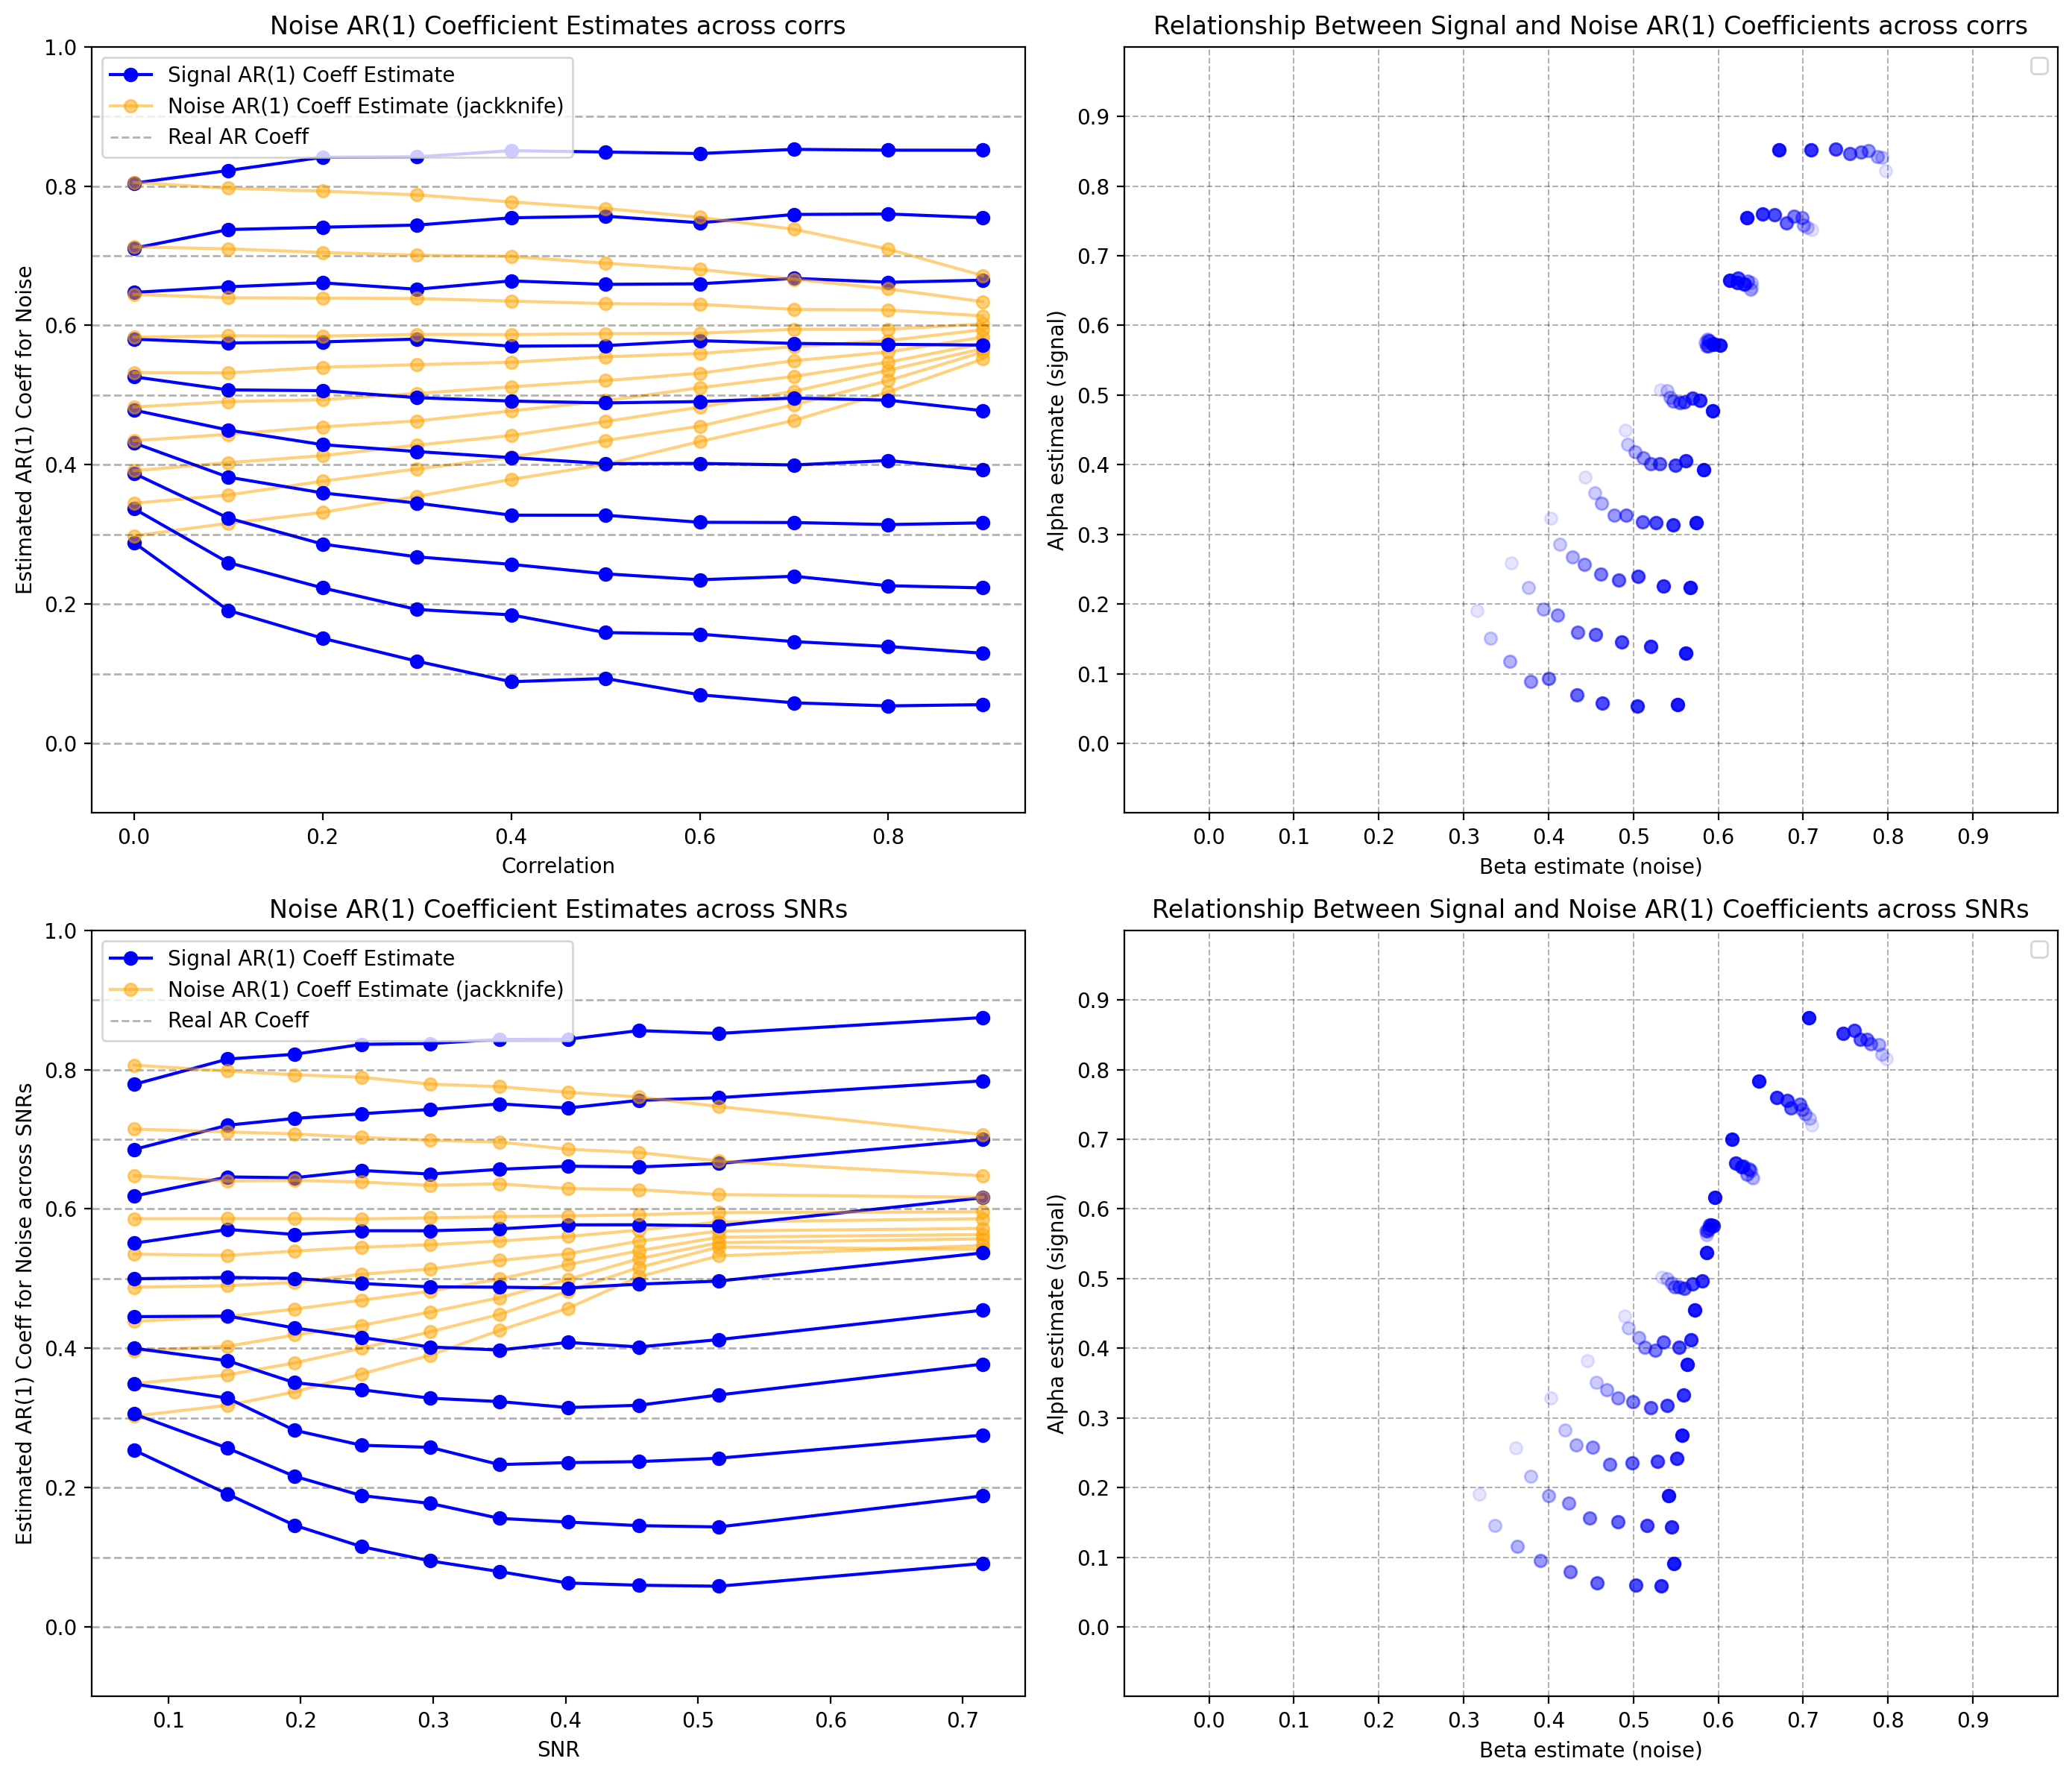

In [226]:
# Plotting
avg_est_beta_ub = np.mean(est_beta_ub, axis=0)
avg_est_ar_coeff = np.mean(run_avg_est_ar_coeff, axis=0)
opacity = np.arange(0,1,0.1)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
# 1. Noise AR(1) coefficient estimates across corr vals
for coeff in range(len(real_ar_coeff)):
    axes[0,0].plot(corrs, avg_est_ar_coeff[coeff,:],'o-', color='blue', label='Signal AR(1) Coeff Estimate' if coeff == 0 else "")
    axes[0,0].plot(corrs, avg_est_beta_ub[coeff,:], 'o-', color='orange', alpha=0.5,  label='Noise AR(1) Coeff Estimate (jackknife)' if coeff == 0 else "")
    axes[0,0].axhline(y=real_ar_coeff[coeff],color='black', alpha=0.3, linewidth='1', linestyle='--', label='Real AR Coeff' if coeff == 0 else "")
axes[0,0].set_ylim([-0.1,1])
axes[0,0].set_xlabel("Correlation")
axes[0,0].set_ylabel("Estimated AR(1) Coeff for Noise")
axes[0,0].legend(loc='upper left')
axes[0,0].set_title("Noise AR(1) Coefficient Estimates across corrs")

# 2. Signal AR(1) coefficient estimates across corr vals
for coeff in range(len(real_ar_coeff)):
    axes[0,1].axhline(y=real_ar_coeff[coeff], color='black', alpha=0.3, linewidth='0.75', linestyle='--')
    axes[0,1].axvline(x=real_ar_coeff[coeff], color='black', alpha=0.3, linewidth='0.75', linestyle='--')

    for corr in range(len(corrs)):
        axes[0,1].scatter(avg_est_beta_ub[coeff,corr], avg_est_ar_coeff[coeff, corr], color='blue', alpha=opacity[corr])        

axes[0,1].set_ylabel("Alpha estimate (signal)")
axes[0,1].set_xlabel("Beta estimate (noise)")
axes[0,1].set_title("Relationship Between Signal and Noise AR(1) Coefficients across corrs")
axes[0,1].legend(loc='upper right')
axes[0,1].set_xlim([-0.1,1])
axes[0,1].set_ylim([-0.1,1])
axes[0,1].set_yticks(corrs)
axes[0,1].set_xticks(corrs)

#----- Plot alpha and beta estimates across SNRs -----
# flatten everything
est_beta_flat = est_beta_ub.reshape(-1)
est_alpha_flat = run_avg_est_ar_coeff.reshape(-1)
snr_flat = np.array(snr_by_corr).flatten()
alpha_true_flat = np.tile(np.repeat(real_ar_coeff, len(corrs)), nLoops)
# bin SNRs by percentiles
snr_bins = np.percentile(snr_flat, np.linspace(0, 100, 11))
snr_bin_centers =  0.5 * (snr_bins[:-1] + snr_bins[1:])
digitized = np.digitize(snr_flat, snr_bins) - 1
digitized = np.clip(digitized, 0, len(snr_bins) - 1)

avg_beta_by_snr = np.zeros((len(real_ar_coeff), len(snr_bin_centers)))
avg_alpha_by_snr = np.zeros((len(real_ar_coeff), len(snr_bin_centers)))

for coeff in range(len(real_ar_coeff)):
    for snr in range(len(snr_bin_centers)):
        mask = (alpha_true_flat == real_ar_coeff[coeff]) & (digitized == snr)
        avg_beta_by_snr[coeff, snr] = np.mean(est_beta_flat[mask])
        avg_alpha_by_snr[coeff, snr] = np.mean(est_alpha_flat[mask])

# 3. Noise AR(1) coefficient estimates across SNRs
for coeff in range(len(real_ar_coeff)):
    axes[1,0].plot(snr_bin_centers, avg_alpha_by_snr[coeff,:],'o-', color='blue', label='Signal AR(1) Coeff Estimate' if coeff == 0 else "")
    axes[1,0].plot(snr_bin_centers, avg_beta_by_snr[coeff,:], 'o-', color='orange', alpha=0.5,  label='Noise AR(1) Coeff Estimate (jackknife)' if coeff == 0 else "")
    axes[1,0].axhline(y=real_ar_coeff[coeff],color='black', alpha=0.3, linewidth='1', linestyle='--', label='Real AR Coeff' if coeff == 0 else "")
axes[1,0].set_ylim([-0.1,1])
axes[1,0].set_xlabel("SNR")
axes[1,0].set_ylabel("Estimated AR(1) Coeff for Noise across SNRs")
axes[1,0].legend(loc='upper left')
axes[1,0].set_title("Noise AR(1) Coefficient Estimates across SNRs")

# 4. Signal AR(1) coefficient estimates across SNRs
opacity = np.arange(0,1.1,0.1)
for coeff in range(len(real_ar_coeff)):
    axes[1,1].axhline(y=real_ar_coeff[coeff], color='black', alpha=0.3, linewidth='0.75', linestyle='--')
    axes[1,1].axvline(x=real_ar_coeff[coeff], color='black', alpha=0.3, linewidth='0.75', linestyle='--')

    for snr in range(len(snr_bin_centers)):
        axes[1,1].scatter(avg_beta_by_snr[coeff, snr], avg_alpha_by_snr[coeff, snr], color='blue', alpha=opacity[snr])        

axes[1,1].set_ylabel("Alpha estimate (signal)")
axes[1,1].set_xlabel("Beta estimate (noise)")
axes[1,1].set_title("Relationship Between Signal and Noise AR(1) Coefficients across SNRs")
axes[1,1].legend(loc='upper right')
axes[1,1].set_xlim([-0.1,1])
axes[1,1].set_ylim([-0.1,1])
axes[1,1].set_yticks(corrs)
axes[1,1].set_xticks(corrs)

plt.tight_layout()
plt.show()


In [195]:
# Train decoders with the previously simulated data
from sklearn.neighbors import KernelDensity

# Dictionary to store beta samples for each alpha
beta_by_alpha = {}
alpha_by_alpha = {}

# Fill dictionary from your simulation
for i, alpha in enumerate(real_ar_coeff):
    beta_vals = est_beta_ub[:, i, :].reshape(-1)  # all beta estimates for this alpha
    beta_by_alpha[alpha] = beta_vals
    alpha_vals = run_avg_est_ar_coeff[:, i, :].reshape(-1)
    alpha_by_alpha[alpha] = alpha_vals


# Store KDE models for each alpha
kde_by_beta = {}
kde_by_alpha = {}

for alpha in real_ar_coeff:
    # fit beta model 
    kde_beta = KernelDensity(kernel='gaussian', bandwidth=0.1)  
    beta_samples = np.array(beta_by_alpha[alpha]).reshape(-1, 1)
    kde_beta.fit(beta_samples)
    kde_by_beta[float(alpha)] = kde_beta

    # fit alpha model 
    kde_alpha = KernelDensity(kernel='gaussian', bandwidth=0.1)  
    alpha_samples = np.array(alpha_by_alpha[alpha]).reshape(-1, 1)
    kde_alpha.fit(alpha_samples)
    kde_by_alpha[float(alpha)] = kde_alpha

# Uniform prior over alphas
prior_alpha = {float(alpha): 1 / len(real_ar_coeff) for alpha in real_ar_coeff}


def decode_alpha_from_beta(beta_obs, kde_by_beta, prior_alpha):
    posterior_unnormalized = {}
    
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        # alpha = float(np.round(alpha, 1))
        log_likelihood = kde_by_beta[alpha].score_samples(np.array([[beta_obs]]))[0]
        likelihood = np.exp(log_likelihood)
        posterior_unnormalized[alpha] = likelihood * prior_alpha[alpha]

    # Normalize
    total = sum(posterior_unnormalized.values())
    posterior = {alpha: val / total for alpha, val in posterior_unnormalized.items()}

    # Return expected alpha 
    expected_alpha = sum(alpha * prob for alpha, prob in posterior.items())
    best_alpha = max(posterior, key=posterior.get)  # mode of posterior
    return best_alpha, posterior



def decode_alpha_from_alpha(alpha_obs, kde_by_alpha, prior_alpha):
    posterior_unnormalized = {}
    
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        # alpha = float(np.round(alpha, 1))
        log_likelihood = kde_by_alpha[alpha].score_samples(np.array([[alpha_obs]]))[0]
        likelihood = np.exp(log_likelihood)
        posterior_unnormalized[alpha] = likelihood * prior_alpha[alpha]

    # Normalize
    total = sum(posterior_unnormalized.values())
    posterior = {alpha: val / total for alpha, val in posterior_unnormalized.items()}

    # Return expected alpha 
    expected_alpha = sum(alpha * prob for alpha, prob in posterior.items())
    best_alpha = max(posterior, key=posterior.get)  # mode of posterior
    return best_alpha, posterior

In [196]:
# Optimize KDE bandwidth individually for each true alpha 
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
import numpy as np

# ---- Parameters ----
bandwidth_grid = np.linspace(0.01, 0.5, 20)  # Try different bandwidths
k_folds = 5

# ---- Placeholder dictionaries ----
best_bw_beta = {}
best_bw_alpha = {}
kde_by_beta = {}
kde_by_alpha = {}

# ---- Cross-validation function ----
def select_best_bandwidth(samples, bandwidth_grid, k_folds=5):
    samples = samples.reshape(-1, 1)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    avg_log_likelihoods = []

    for bw in bandwidth_grid:
        log_likelihoods = []
        for train_idx, val_idx in kf.split(samples):
            train_samples = samples[train_idx]
            val_samples = samples[val_idx]
            
            kde = KernelDensity(kernel='gaussian', bandwidth=bw)
            kde.fit(train_samples)
            ll = kde.score(val_samples)  # average log-likelihood
            log_likelihoods.append(ll)

        avg_log_likelihoods.append(np.mean(log_likelihoods))

    best_bw = bandwidth_grid[np.argmax(avg_log_likelihoods)]
    return best_bw

# ---- Perform bandwidth selection and train final KDEs ----
for alpha in real_ar_coeff:
    alpha = float(alpha)

    # Get samples
    beta_samples = np.array(beta_by_alpha[alpha]).reshape(-1)
    alpha_samples = np.array(alpha_by_alpha[alpha]).reshape(-1)

    # ---- Select best bandwidth for each ----
    bw_beta = select_best_bandwidth(beta_samples, bandwidth_grid, k_folds)
    bw_alpha = select_best_bandwidth(alpha_samples, bandwidth_grid, k_folds)

    # ---- Store best bandwidths ----
    best_bw_beta[alpha] = bw_beta
    best_bw_alpha[alpha] = bw_alpha

    # ---- Fit KDEs with optimal bandwidths ----
    kde_b = KernelDensity(kernel='gaussian', bandwidth=bw_beta).fit(beta_samples.reshape(-1, 1))
    kde_a = KernelDensity(kernel='gaussian', bandwidth=bw_alpha).fit(alpha_samples.reshape(-1, 1))

    kde_by_beta[alpha] = kde_b
    kde_by_alpha[alpha] = kde_a

# Uniform prior (same as before)
prior_alpha = {float(alpha): 1 / len(real_ar_coeff) for alpha in real_ar_coeff}

def decode_alpha_from_beta(beta_obs, kde_by_beta, prior_alpha):
    posterior_unnormalized = {}
    
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        # alpha = float(np.round(alpha, 1))
        log_likelihood = kde_by_beta[alpha].score_samples(np.array([[beta_obs]]))[0]
        likelihood = np.exp(log_likelihood)
        posterior_unnormalized[alpha] = likelihood * prior_alpha[alpha]

    # Normalize
    total = sum(posterior_unnormalized.values())
    posterior = {alpha: val / total for alpha, val in posterior_unnormalized.items()}

    # Return expected alpha 
    expected_alpha = sum(alpha * prob for alpha, prob in posterior.items())
    best_alpha = max(posterior, key=posterior.get)  # mode of posterior
    return best_alpha, posterior



def decode_alpha_from_alpha(alpha_obs, kde_by_alpha, prior_alpha):
    posterior_unnormalized = {}
    
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        # alpha = float(np.round(alpha, 1))
        log_likelihood = kde_by_alpha[alpha].score_samples(np.array([[alpha_obs]]))[0]
        likelihood = np.exp(log_likelihood)
        posterior_unnormalized[alpha] = likelihood * prior_alpha[alpha]

    # Normalize
    total = sum(posterior_unnormalized.values())
    posterior = {alpha: val / total for alpha, val in posterior_unnormalized.items()}

    # Return expected alpha 
    expected_alpha = sum(alpha * prob for alpha, prob in posterior.items())
    best_alpha = max(posterior, key=posterior.get)  # mode of posterior
    return best_alpha, posterior


Visualize some properties of the decoders:

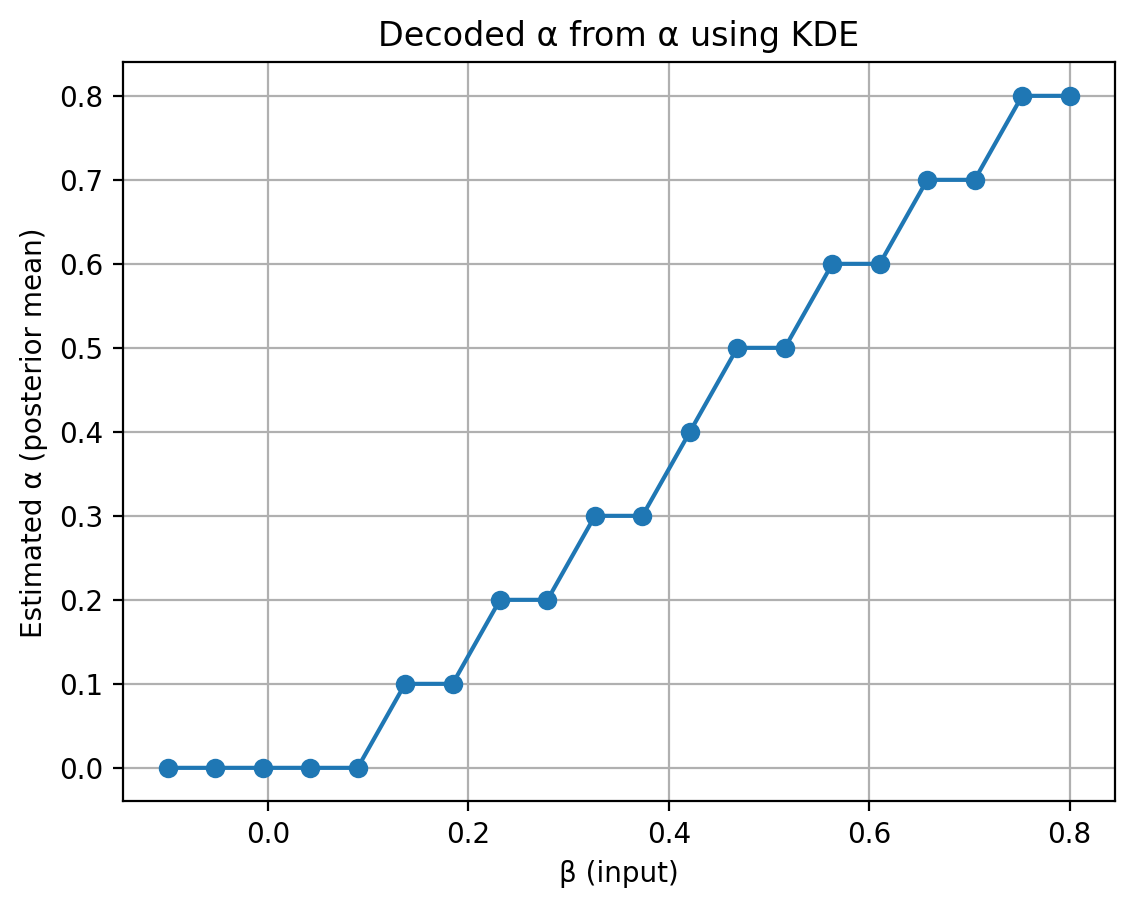

In [201]:
test_betas = np.linspace(-0.1, 0.8, 20)
decoded = [decode_alpha_from_alpha(b, kde_by_alpha, prior_alpha)[0] for b in test_betas]

plt.plot(test_betas, decoded, marker='o')
plt.xlabel("β (input)")
plt.ylabel("Estimated α (posterior mean)")
# plt.title("Decoded α from β using KDE")
plt.title("Decoded α from α using KDE")
plt.grid(True)
plt.show()

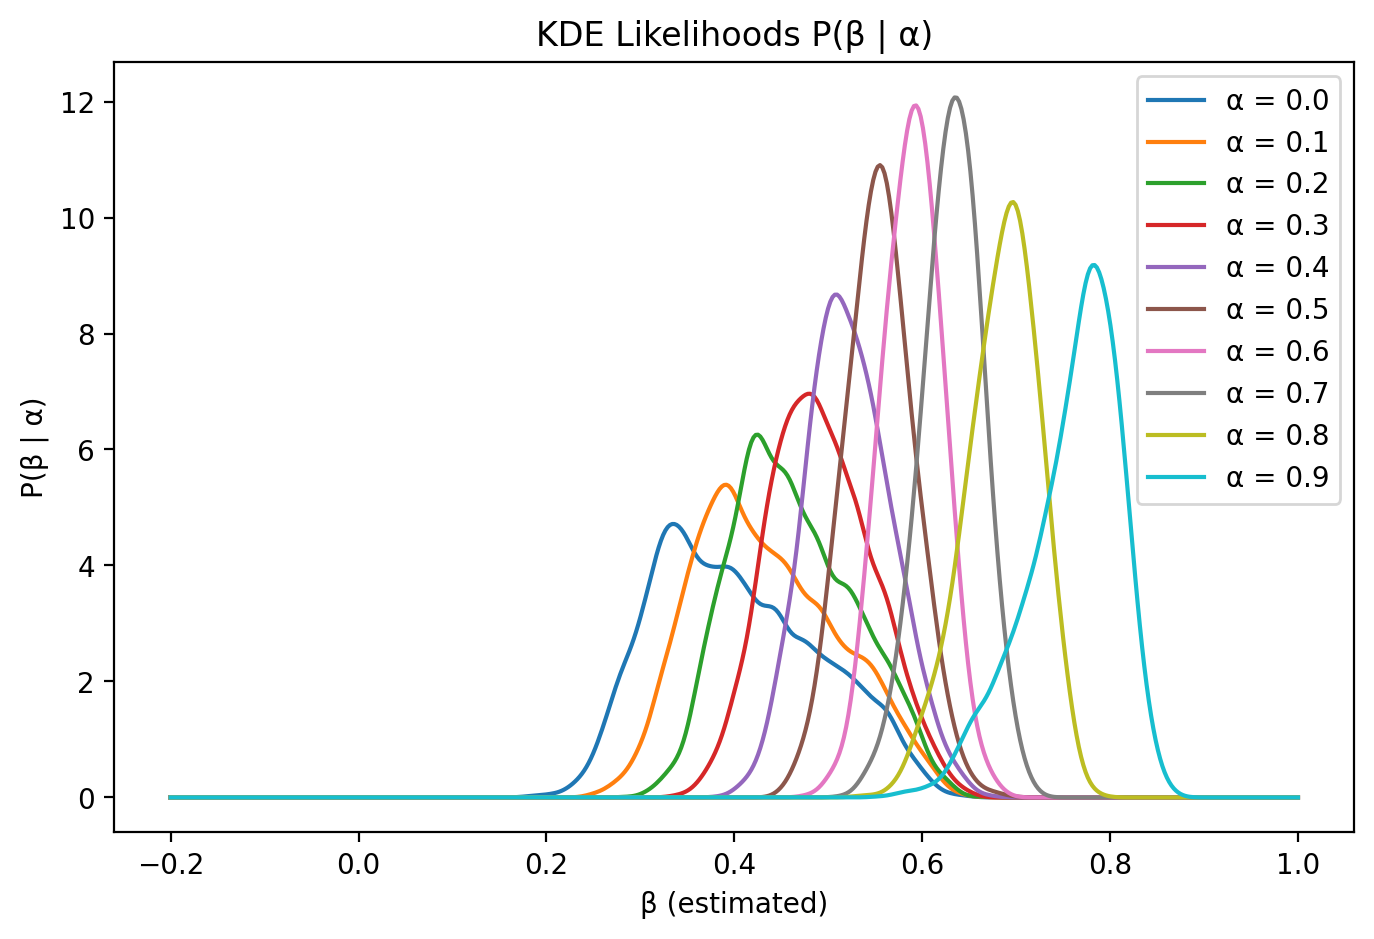

In [205]:
x_vals = np.linspace(-0.2, 1.0, 500).reshape(-1, 1)
plt.figure(figsize=(8, 5))
for alpha in real_ar_coeff:
    alpha = float(alpha)
    log_dens = kde_by_beta[alpha].score_samples(x_vals)
    plt.plot(x_vals, np.exp(log_dens), label=f'α = {alpha:.1f}')
plt.xlabel('β (estimated)')
# plt.xlabel('α̂')
plt.ylabel('P(β | α)')
# plt.ylabel('P(α̂ | α)')
plt.title('KDE Likelihoods P(β | α)')
# plt.title('KDE Likelihoods P(α̂ | α)')
plt.legend()
plt.show()

Test the decoders on newly simulated data to verify.

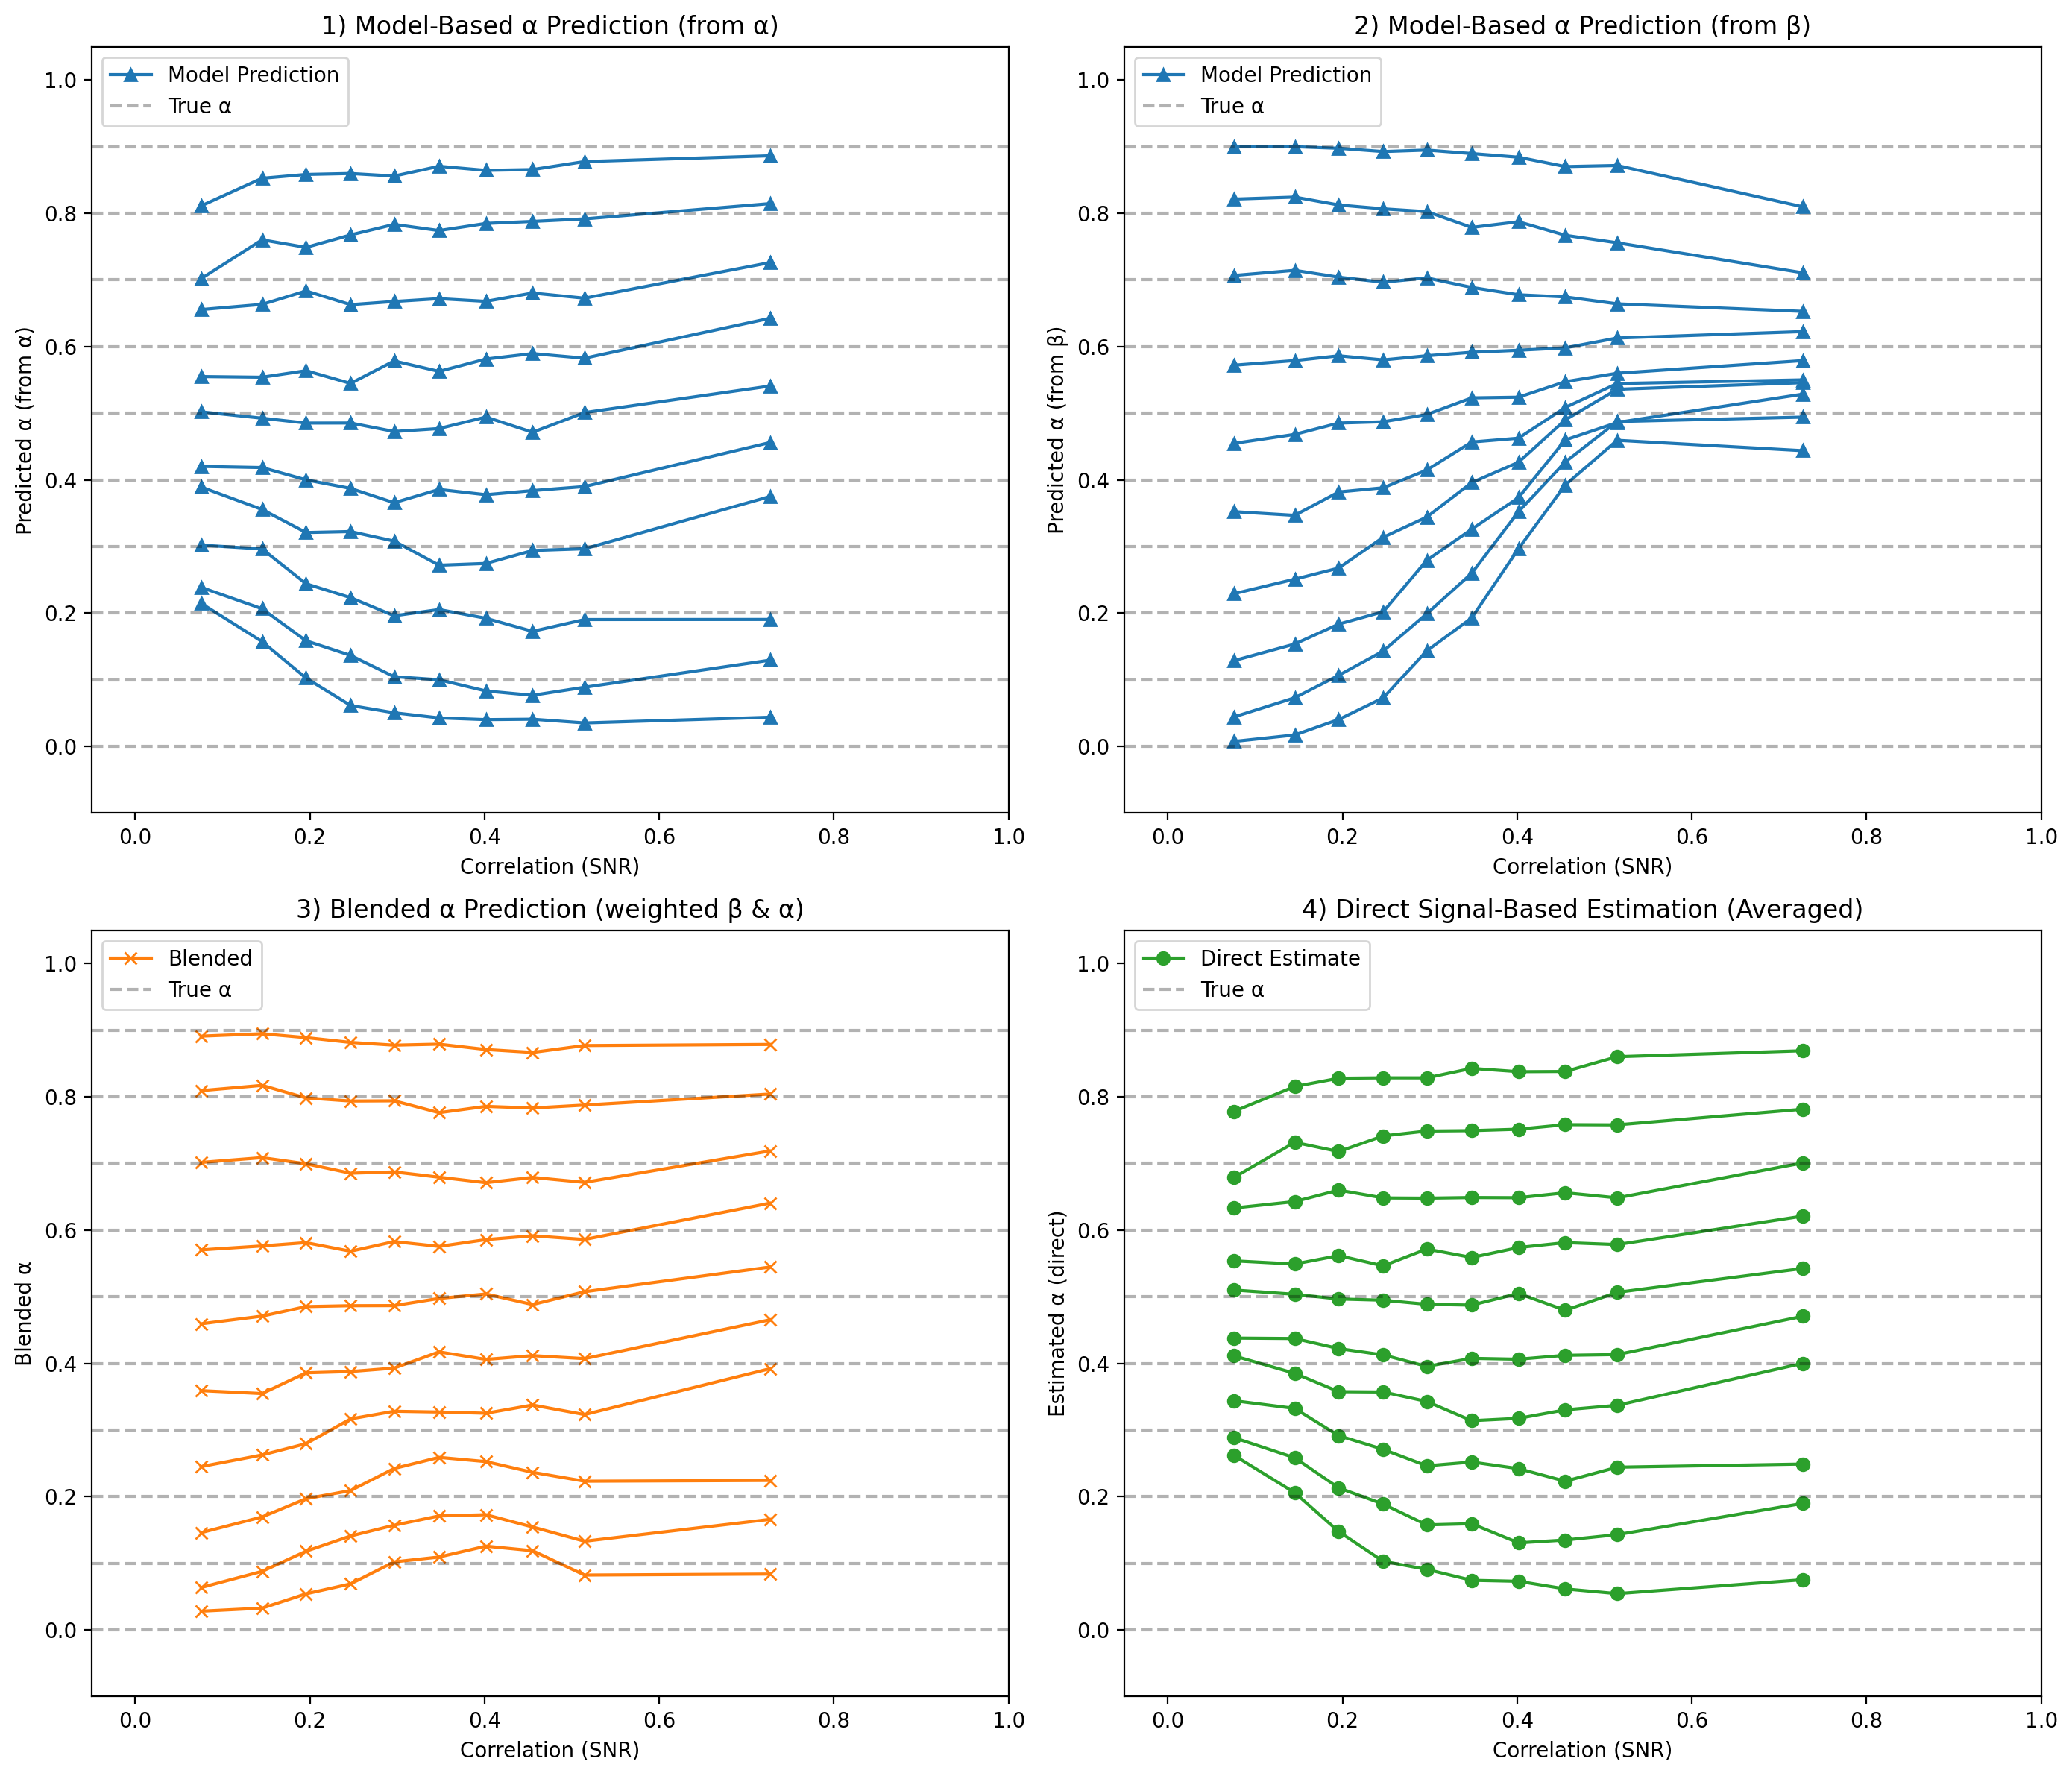

In [258]:
from sklearn.linear_model import LinearRegression

nLoops = 100
nT = 100
nRuns = 10
corrs = np.arange(0, 1, 0.1)

# # --- Define Bayesian Blending Functions ---
# def blend_posteriors(posterior1, posterior2, weight):
#     posterior_blend = {}
#     for alpha in posterior1:
#         p1 = posterior1[alpha]
#         p2 = posterior2[alpha]
#         posterior_blend[alpha] = weight * p1 + (1-weight) * p2

#     total = sum(posterior_blend.values())
#     posterior_blend = {alpha: val / total for alpha, val in posterior_blend.items()}
#     return posterior_blend

# def posterior_mean(posterior):
#     return sum(alpha * prob for alpha, prob in posterior.items())

# def posterior_mode(posterior):
#     return max(posterior, key=posterior.get)

# --- Initialize arrays ---
sim_data_test = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
est_beta_ub_test = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
run_avg_est_ar_coeff_test = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

alpha_true_list, alpha_pred_list, beta_pred_list, alpha_direct_list, snr_list = [], [], [], [], []

# --- Simulation + Inference Loop ---
for i, alpha in enumerate(real_ar_coeff):
    for j, corr in enumerate(corrs):
        for loop in range(nLoops):
            # Simulate time series data
            sim = make_correlated_arp(alpha, nT, n_series=nRuns, corr=corr)
            sim_data_test[loop, i, j] = sim

            # Estimate β (from noise)
            est_beta = fit_ind_noise_to_ar1(sim, nRuns)
            est_beta_ub_test[loop, i, j] = est_beta

            # Estimate α (direct from signal)
            avg_series = np.mean(sim, axis=0)
            zs_avg = zs(avg_series)
            ar1_model = sm.tsa.AutoReg(zs_avg, lags=1).fit()
            est_alpha = ar1_model.params[1]
            run_avg_est_ar_coeff_test[loop, i, j] = est_alpha

            # Predict α from estimated β using saved model
            beta_val = np.array([[est_beta]])
            beta_pred, _ = decode_alpha_from_beta(est_beta, kde_by_beta, prior_alpha)
            alpha_pred, _ = decode_alpha_from_beta(est_alpha, kde_by_alpha, prior_alpha)

            # Estimate SNR
            snr = estimate_snr(sim)

            # Store all
            alpha_true_list.append(alpha)
            beta_pred_list.append(beta_pred)
            alpha_pred_list.append(alpha_pred)
            alpha_direct_list.append(est_alpha)
            snr_list.append(snr)

# --- Convert to arrays ---
alpha_true_array = np.array(alpha_true_list)
beta_pred_array = np.array(beta_pred_list)
alpha_pred_array = np.array(alpha_pred_list)
alpha_direct_array = np.array(alpha_direct_list)
snr_array = np.array(snr_list)


# --- Bin SNR values
# snr_bins = np.linspace(0, max(snr_list), 10)
snr_bins = np.percentile(snr_list, np.linspace(0, 100, 11))
snr_bin_centers =  0.5 * (snr_bins[:-1] + snr_bins[1:])
digitized = np.digitize(snr_list, snr_bins) - 1
digitized = np.clip(digitized, 0, len(snr_bins) - 1)

# --- Compute loop-averaged estimates per (alpha, SNR) ---
avg_beta_pred_model = np.zeros((len(real_ar_coeff), len(snr_bin_centers)))
avg_alpha_pred_model = np.zeros((len(real_ar_coeff), len(snr_bin_centers)))
avg_direct_est = np.zeros((len(real_ar_coeff), len(snr_bin_centers)))

for alpha in range(len(real_ar_coeff)):
    for snr_bin in range(len(snr_bin_centers)):
        mask = (alpha_true_array == real_ar_coeff[alpha]) & (digitized == snr_bin)
        avg_beta_pred_model[alpha, snr_bin] = np.mean(beta_pred_array[mask])
        avg_alpha_pred_model[alpha, snr_bin] = np.mean(alpha_pred_array[mask])
        avg_direct_est[alpha, snr_bin] = np.mean(alpha_direct_array[mask])

# --- Blended prediction ---
# # 1) optimize the blending weights 
# # Compute optimal weights per sample (analytical solution)
# eps = 1e-8
# numerator = (alpha_true_array - alpha_pred_array) * (beta_pred_array - alpha_pred_array)
# denominator = (beta_pred_array - alpha_pred_array)**2 + eps
# w_opt = numerator / denominator
# w_opt = np.clip(w_opt, 0, 1)  # Clip between 0 and 1 for stability

# # Fit linear regression: SNR -> optimal weight
# valid_mask = ~np.isnan(w_opt)
# reg = LinearRegression().fit(snr_array[valid_mask].reshape(-1, 1), w_opt[valid_mask].reshape(-1, 1))
# snr_fit = np.linspace(0, 1, 100)
# w_pred = reg.predict(snr_fit.reshape(-1, 1))


# linear weighted average
min_weight = 0.1
blend_weights = np.clip(
    np.tile(np.linspace(1, 0, len(snr_bin_centers)), (len(real_ar_coeff), 1)),
    min_weight, 1 - min_weight
)
blended_pred_model = blend_weights * avg_beta_pred_model + (1 - blend_weights) * avg_alpha_pred_model

# Bayesian weighted average (model uncertainty)
# blended_pred_model = np.zeros((len(real_ar_coeff), len(snr_bins)))
# for alpha in range(len(real_ar_coeff)):
#     for snr_bin in range(len(snr_bins)):
#         mask = (alpha_true_array == real_ar_coeff[alpha]) & (digitized == snr_bin)

#         if not np.any(mask):
#             blended_pred_model[alpha, snr_bin] = np.nan
#             continue

#         # Extract posteriors for all matching simulations in this bin
#         blended_vals = []
#         for m in np.where(mask)[0]:
#             est_alpha = alpha_pred_array[m]
#             est_beta = beta_pred_array[m]

#             _, alpha_posterior = decode_alpha_from_alpha(est_alpha, kde_by_alpha, prior_alpha)
#             _, beta_posterior = decode_alpha_from_beta(est_beta, kde_by_beta, prior_alpha)

#             snr = snr_array[m]
#             w = snr / (snr + 1)

#             # Blend and get posterior mean
#             blended_posterior = blend_posteriors(beta_posterior, alpha_posterior, weight=w)
#             blended_val = posterior_mean(blended_posterior)
#             blended_vals.append(blended_val)

#         blended_pred_model[alpha, snr_bin] = np.mean(blended_vals)


# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot direct signal-based estimates


# Plot model-based predictions (from alpha)
for i, alpha in enumerate(real_ar_coeff):
    axes[0,0].plot(snr_bin_centers, avg_alpha_pred_model[i], marker='^', color='tab:blue',
                 label='Model Prediction' if i == 0 else "")
    axes[0,0].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[0,0].set(title="1) Model-Based α Prediction (from α)",
            xlabel="Correlation (SNR)", ylabel="Predicted α (from α)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[0,0].legend(loc='upper left')

# Plot model-based predictions (from beta)
for i, alpha in enumerate(real_ar_coeff):
    axes[0,1].plot(snr_bin_centers, avg_beta_pred_model[i], marker='^', color='tab:blue',
                 label='Model Prediction' if i == 0 else "")
    axes[0,1].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[0,1].set(title="2) Model-Based α Prediction (from β)",
            xlabel="Correlation (SNR)", ylabel="Predicted α (from β)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[0,1].legend(loc='upper left')

# Subplot 2: Blended predictions
for i, alpha in enumerate(real_ar_coeff):
    axes[1, 0].plot(snr_bin_centers, blended_pred_model[i], marker='x', color='tab:orange',
                    label='Blended' if i == 0 else "")
    axes[1, 0].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")
axes[1, 0].set(title="3) Blended α Prediction (weighted β & α)",
            xlabel="Correlation (SNR)", ylabel="Blended α",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[1, 0].legend(loc='upper left')

# Subplot 3: From fitting AR(1) to averaged data - signals
for i, alpha in enumerate(real_ar_coeff):
    axes[1,1].plot(snr_bin_centers, avg_direct_est[i], marker='o', color='tab:green',
                 label='Direct Estimate' if i == 0 else "")
    axes[1,1].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[1,1].set(title="4) Direct Signal-Based Estimation (Averaged)",
            xlabel="Correlation (SNR)", ylabel="Estimated α (direct)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[1,1].legend(loc='upper left')


plt.tight_layout()
plt.show()



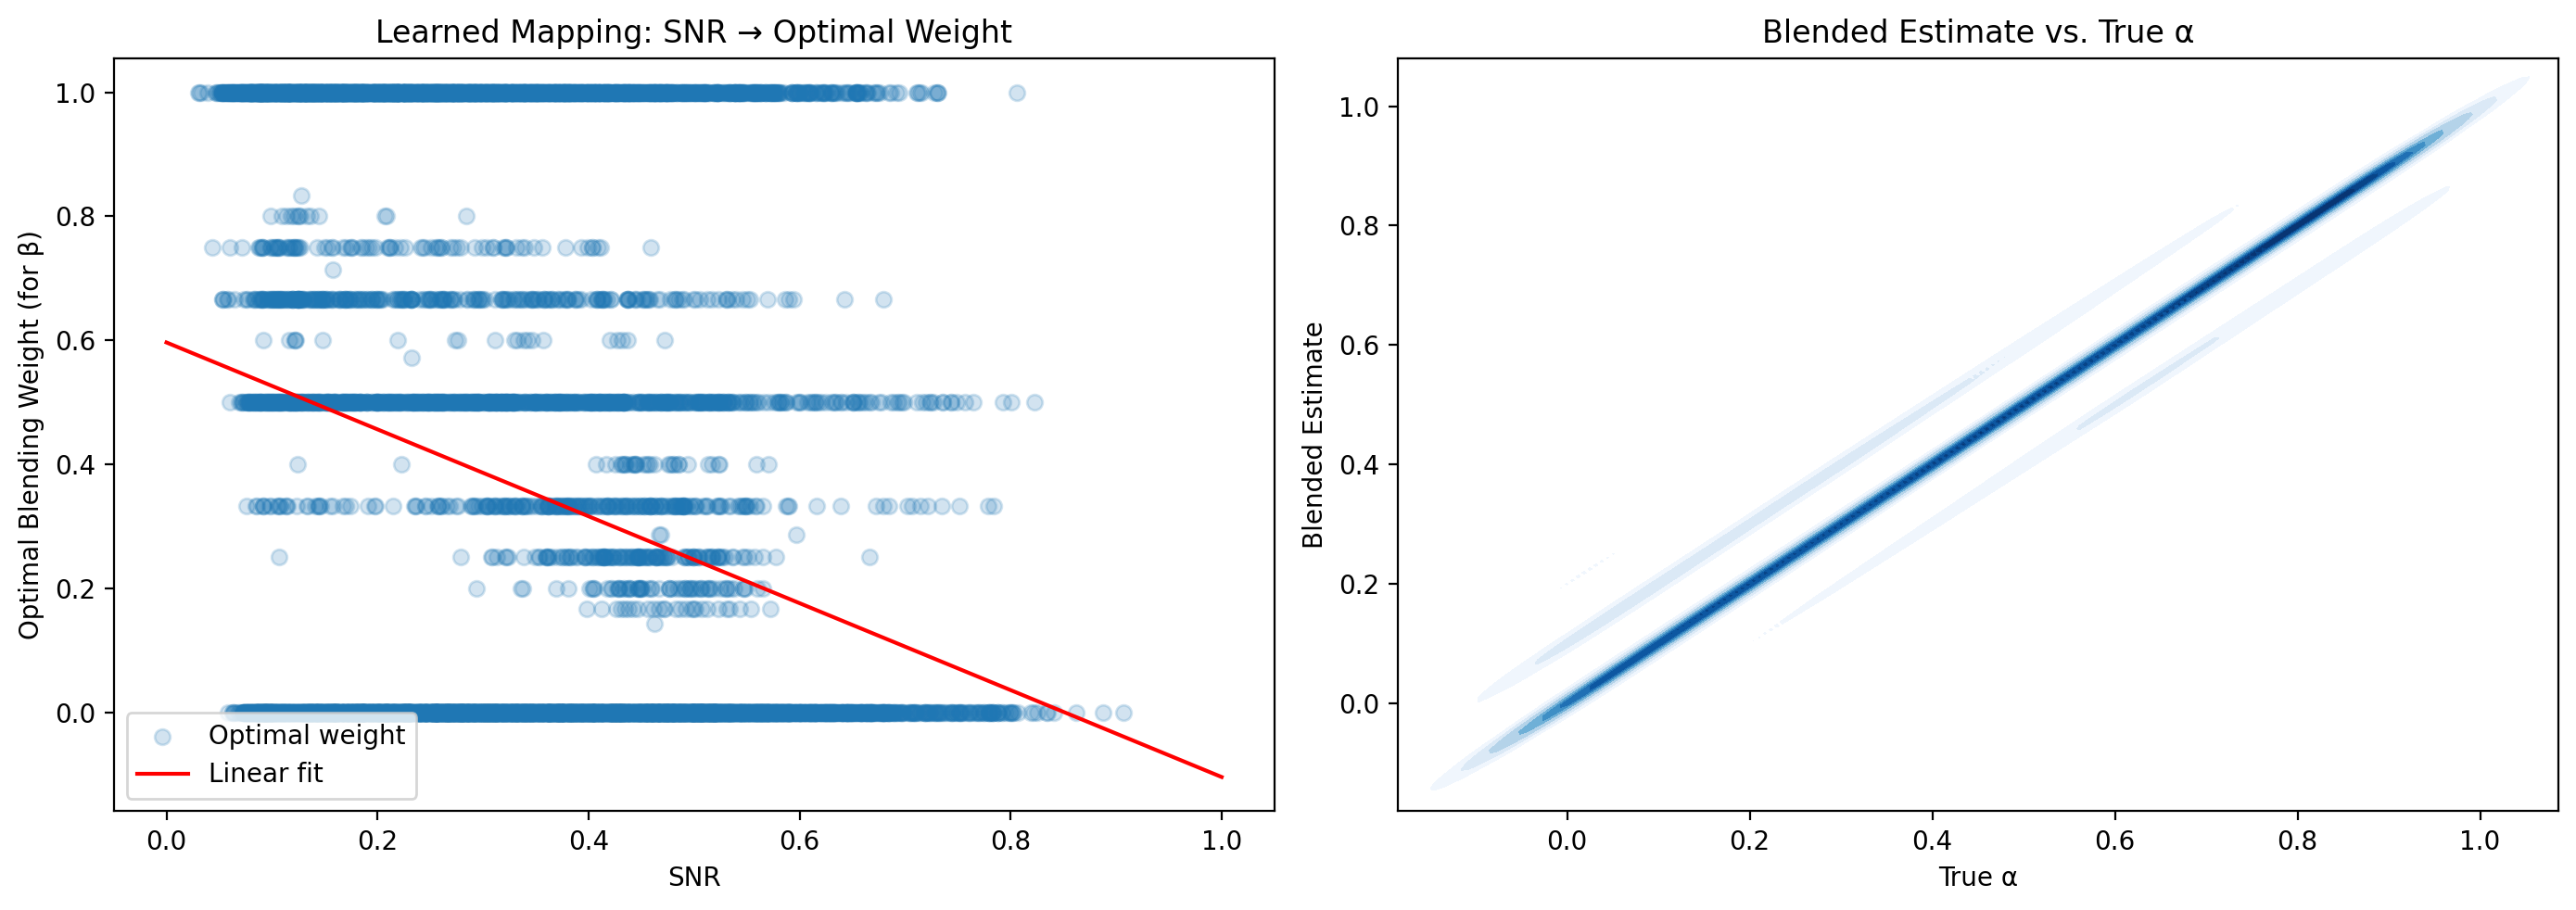

In [259]:
import pandas as pd

eps = 1e-8
numerator = (alpha_true_array - alpha_pred_array) * (beta_pred_array - alpha_pred_array)
denominator = (beta_pred_array - alpha_pred_array)**2 + eps
w_opt = numerator / denominator
w_opt = np.clip(w_opt, 0, 1)  # Clip between 0 and 1 for stability

# Fit linear regression: SNR -> optimal weight
valid_mask = ~np.isnan(w_opt)
reg = LinearRegression().fit(snr_array[valid_mask].reshape(-1, 1), w_opt[valid_mask].reshape(-1, 1))
snr_fit = np.linspace(0, 1, 100)
w_pred = reg.predict(snr_fit.reshape(-1, 1))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter actual vs fitted
ax[0].scatter(snr_array, w_opt, alpha=0.2, label="Optimal weight")
ax[0].plot(snr_fit, w_pred, color='red', label="Linear fit")
ax[0].set_title("Learned Mapping: SNR → Optimal Weight")
ax[0].set_xlabel("SNR")
ax[0].set_ylabel("Optimal Blending Weight (for β)")
ax[0].legend()

# Heatmap of blending outcome
blended = w_opt * beta_pred_array + (1 - w_opt) * alpha_pred_array
df = pd.DataFrame({'true': alpha_true_array, 'blended': blended})
sns.kdeplot(data=df, x='true', y='blended', ax=ax[1], fill=True, cmap="Blues")
ax[1].set_title("Blended Estimate vs. True α")
ax[1].set_xlabel("True α")
ax[1].set_ylabel("Blended Estimate")

plt.tight_layout()
plt.show()

In [247]:
alpha_true_array.shape

(10000,)

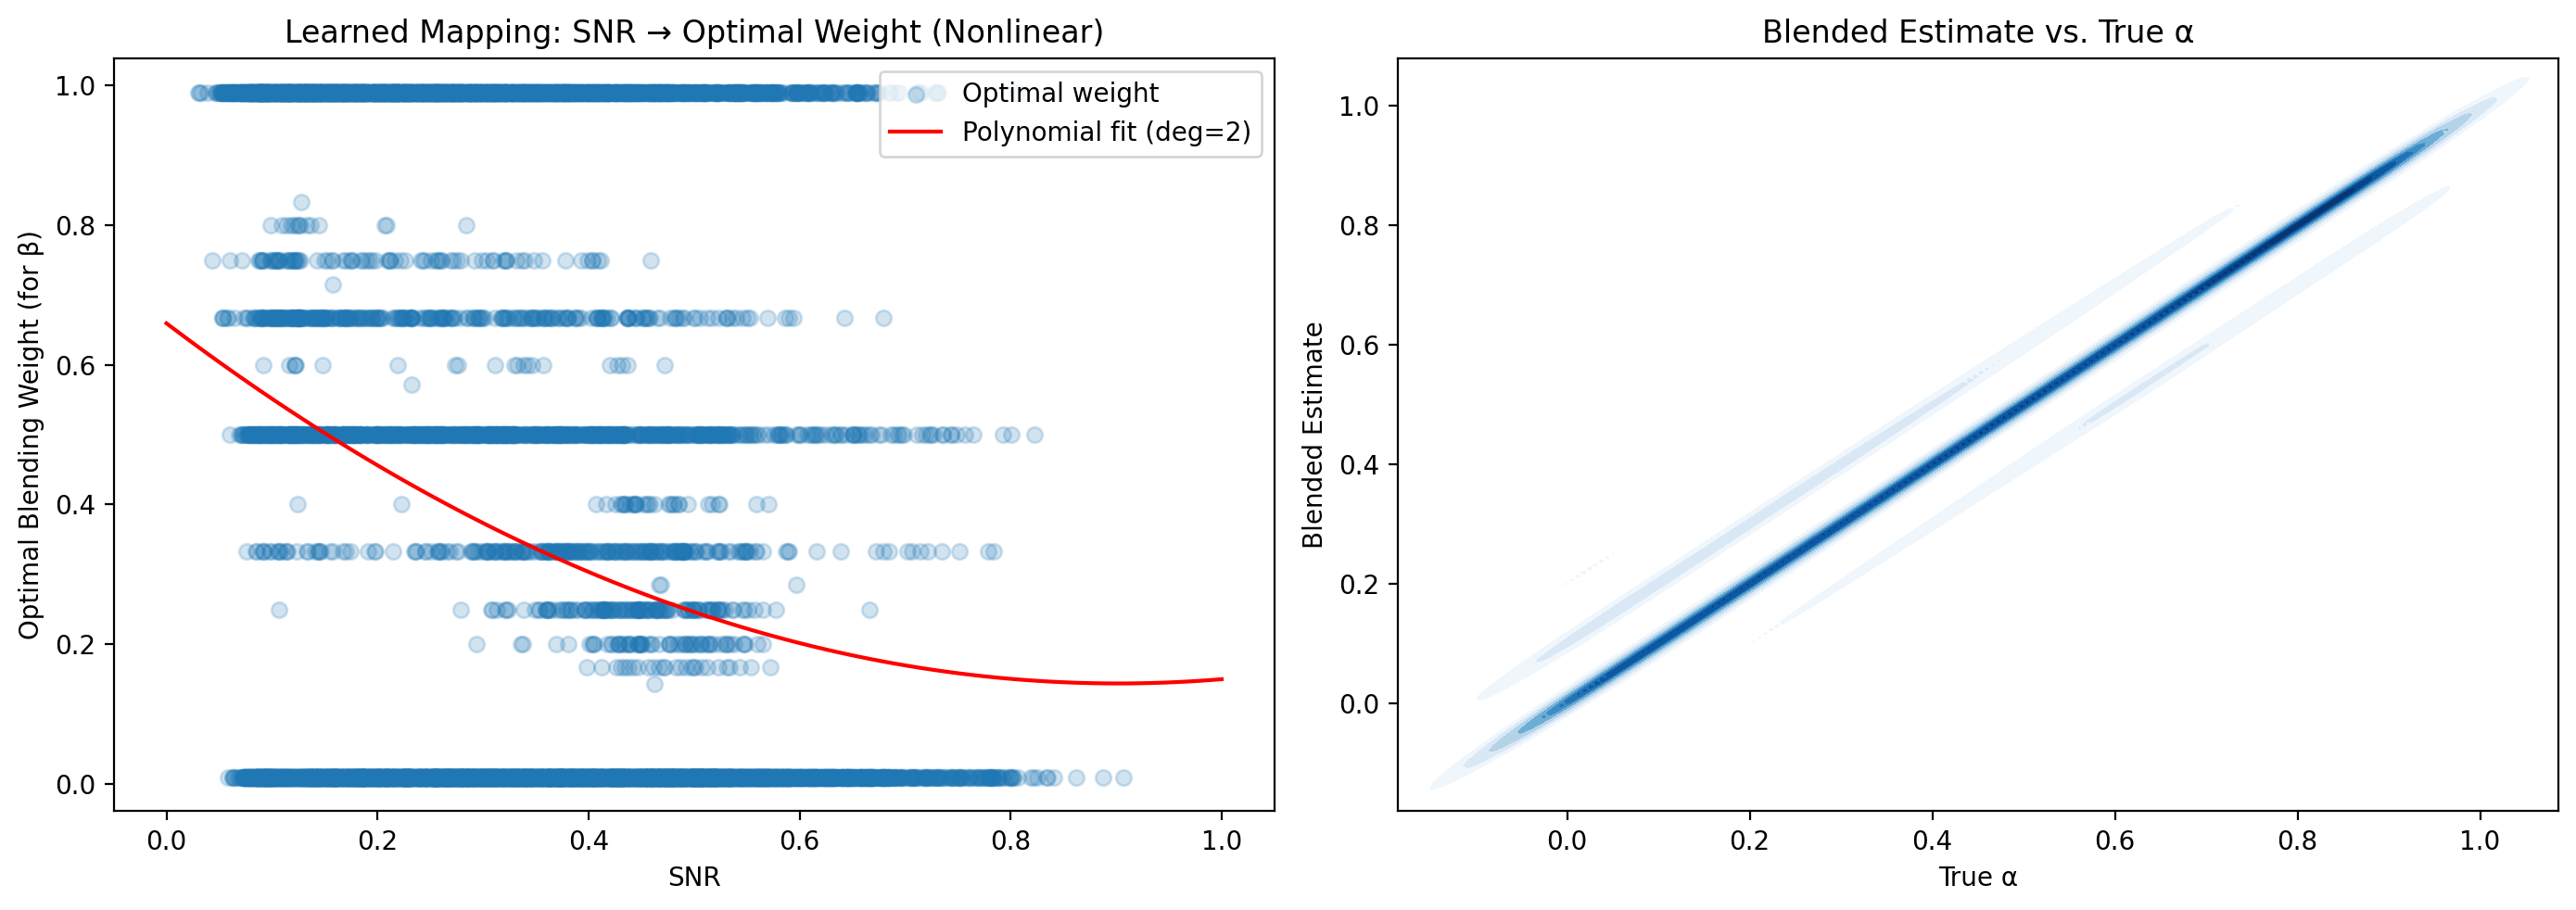

In [264]:
# nonlinear weighting
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit

eps = 1e-8
numerator = (alpha_true_array - alpha_pred_array) * (beta_pred_array - alpha_pred_array)
denominator = (beta_pred_array - alpha_pred_array)**2 + eps
w_opt = numerator / denominator
w_opt = np.clip(w_opt, 0.01, 0.99)  # Clip between 0 and 1 for stability

# --- Fit polynomial regression (nonlinear) ---
valid_mask = ~np.isnan(w_opt)
X = snr_array[valid_mask].reshape(-1, 1)
y = w_opt[valid_mask].reshape(-1, 1)

# Polynomial degree can be adjusted (2 is quadratic)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)

snr_fit = np.linspace(0, 1, 100).reshape(-1, 1)
w_pred = poly_model.predict(snr_fit)
# ----------------------------------------------

# ------------- Fit sigmoid --------------------
# def sigmoid(x, a, b):
#     return 1 / (1 + np.exp(-a * (x - b)))

# valid_mask = ~np.isnan(w_opt)
# x_data = snr_array[valid_mask]
# y_data = w_opt[valid_mask]
# params, _ = curve_fit(
#     sigmoid, x_data, y_data,
#     p0=[-20, 0.3],  # start with a negative slope
#     bounds=([-100, 0], [0, 1]),  # a < 0 (decreasing), b ∈ [0, 1]
#     maxfev=10000
# )
# # # fit on the average
# # w_opt = np.array(w_opt)
# # snr_array = np.array(snr_array)
# # avg_w_per_bin = np.array([
# #     np.nanmean(w_opt[digitized == i]) for i in range(len(snr_bin_centers))
# # ])
# # params, _ = curve_fit(
# #     sigmoid, snr_bin_centers, avg_w_per_bin,
# #     p0=[-20, 0.3],  # steeper slope, centered near low SNR
# #     bounds=([-100, 0], [0, 1]),  # a < 0 (decreasing), b ∈ [0, 1]
# #     maxfev=10000
# # )

# a_fit, b_fit = params
# snr_fit = np.linspace(0, 1, 100)
# w_pred = sigmoid(snr_fit, a_fit, b_fit)

# print("Sigmoid fit parameters: a =", a_fit, "b =", b_fit)

# --- Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter actual vs fitted
ax[0].scatter(snr_array, w_opt, alpha=0.2, label="Optimal weight")
ax[0].plot(snr_fit, w_pred, color='red', label="Polynomial fit (deg=2)")
# ax[0].plot(snr_bin_centers, avg_w_per_bin, 'o', color='black', label='Binned Averages')
ax[0].set_title("Learned Mapping: SNR → Optimal Weight (Nonlinear)")
ax[0].set_xlabel("SNR")
ax[0].set_ylabel("Optimal Blending Weight (for β)")
ax[0].legend()

# Heatmap of blending outcome
blended = w_opt * beta_pred_array + (1 - w_opt) * alpha_pred_array
df = pd.DataFrame({'true': alpha_true_array, 'blended': blended})
sns.kdeplot(data=df, x='true', y='blended', ax=ax[1], fill=True, cmap="Blues")
ax[1].set_title("Blended Estimate vs. True α")
ax[1].set_xlabel("True α")
ax[1].set_ylabel("Blended Estimate")

plt.tight_layout()
plt.show()


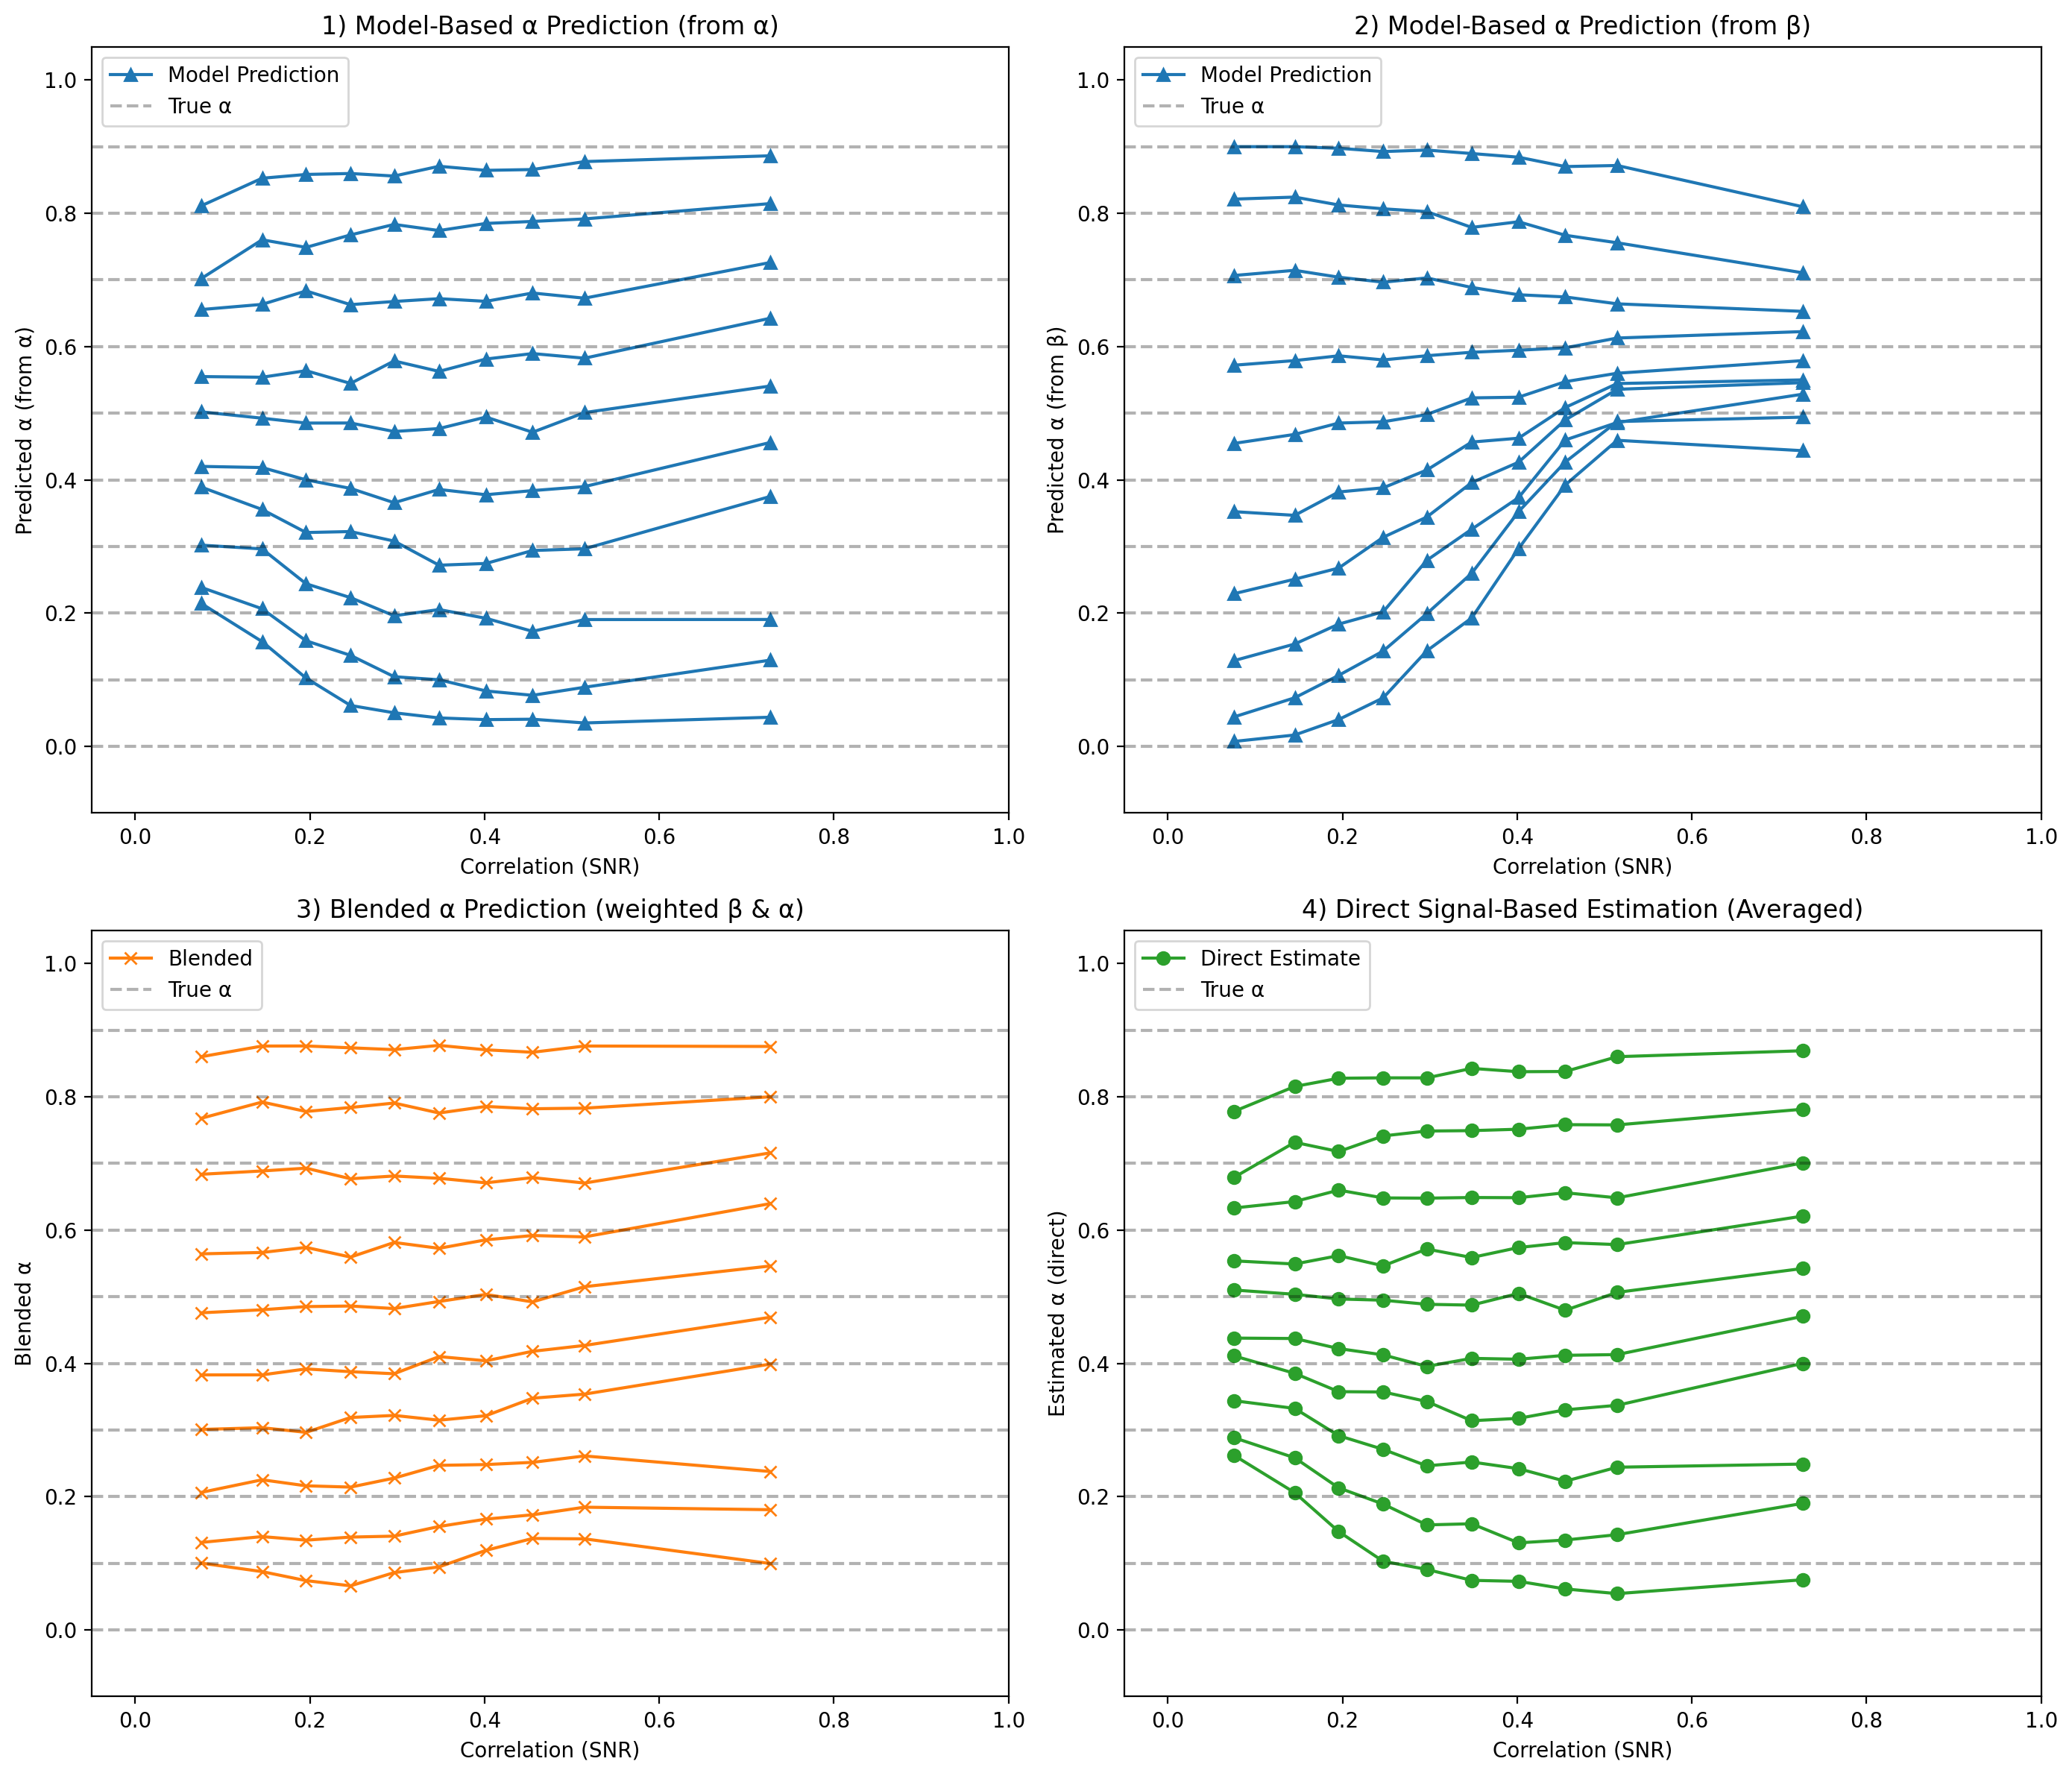

In [262]:
snr_bins = np.percentile(snr_list, np.linspace(0, 100, 11))
snr_bin_centers = 0.5 * (snr_bins[:-1] + snr_bins[1:])
# w_opt = reg.predict(snr_bin_centers.reshape(-1, 1))
# w_opt = poly_model.predict(snr_bin_centers.reshape(-1, 1))
w_opt = sigmoid(snr_bin_centers, a_fit, b_fit)  # shape (10,)
blended_pred_model = w_opt * avg_beta_pred_model + (1 - w_opt) * avg_alpha_pred_model

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot direct signal-based estimates


# Plot model-based predictions (from alpha)
for i, alpha in enumerate(real_ar_coeff):
    axes[0,0].plot(snr_bin_centers, avg_alpha_pred_model[i], marker='^', color='tab:blue',
                 label='Model Prediction' if i == 0 else "")
    axes[0,0].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[0,0].set(title="1) Model-Based α Prediction (from α)",
            xlabel="Correlation (SNR)", ylabel="Predicted α (from α)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[0,0].legend(loc='upper left')

# Plot model-based predictions (from beta)
for i, alpha in enumerate(real_ar_coeff):
    axes[0,1].plot(snr_bin_centers, avg_beta_pred_model[i], marker='^', color='tab:blue',
                 label='Model Prediction' if i == 0 else "")
    axes[0,1].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[0,1].set(title="2) Model-Based α Prediction (from β)",
            xlabel="Correlation (SNR)", ylabel="Predicted α (from β)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[0,1].legend(loc='upper left')

# Subplot 2: Blended predictions
for i, alpha in enumerate(real_ar_coeff):
    axes[1, 0].plot(snr_bin_centers, blended_pred_model[i], marker='x', color='tab:orange',
                    label='Blended' if i == 0 else "")
    axes[1, 0].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")
axes[1, 0].set(title="3) Blended α Prediction (weighted β & α)",
            xlabel="Correlation (SNR)", ylabel="Blended α",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[1, 0].legend(loc='upper left')

# Subplot 3: From fitting AR(1) to averaged data - signals
for i, alpha in enumerate(real_ar_coeff):
    axes[1,1].plot(snr_bin_centers, avg_direct_est[i], marker='o', color='tab:green',
                 label='Direct Estimate' if i == 0 else "")
    axes[1,1].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[1,1].set(title="4) Direct Signal-Based Estimation (Averaged)",
            xlabel="Correlation (SNR)", ylabel="Estimated α (direct)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[1,1].legend(loc='upper left')


plt.tight_layout()
plt.show()


Now decode real data.

In [ ]:
path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data'
os.chdir(path=path)
cwd = os.getcwd()  # Get current working directory
print("Current Working Directory:", cwd)

Current Working Directory: /Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/language


In [15]:
# path = '/Users/jiamingxu/Desktop/Language_straightening/data/language/AA_wheretheressmoke.hf5'
path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/language/AA_wheretheressmoke.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    # get rid of the first 50 TRs (due to onset effect in AC)
    response_trials = response_trials[:, 50:, :]
    print(response_trials.shape) 

subject, xfm = 'AA', '20180905AA-sg-auto'
mask = cortex.db.get_mask(subject, xfm)

(10, 241, 95556)


In [16]:
response_trials.shape[0]

10

In [21]:
# choose functional roi 
f_rois = ['AC','sPMv']
f_roi_voxs = {} # get indices of roi voxels in cortical map
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

# choose anatomical roi (PFC & precuneus)
path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/rois'
os.chdir(path=path)
a_roi = ['parsopercularis','parstriangularis','superiorfrontal','rostralmiddlefrontal','caudalmiddlefrontal','frontalpole','precuneus']
roi_data = np.load(f'{subject}_roi.npy', allow_pickle=True).item()
a_roi_voxs = {}
for roi in a_roi:
    a_roi_voxs[roi] = roi_data[roi]
    
# combine PFC rois
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]


# combine functional and anatomical
roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

# print number of voxels in each ROI
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

Cutting 0 overlapping voxels (should be < ~50)
AC: 2124 items
sPMv: 271 items
precuneus: 2845 items
prefrontal: 15222 items


In [274]:
nRuns = response_trials.shape[0]
keys = roi_voxs.keys()
run_avg_est_alpha = {key: np.zeros(1) for key in keys}
alpha_pred = {key: np.zeros(1) for key in keys}
est_beta_ub = {key: np.zeros(1) for key in keys}
beta_pred = {key: np.zeros(1) for key in keys}
blended_pred = {key: np.zeros(1) for key in keys}


for roi in roi_voxs:
    roi_response_trials = np.mean(response_trials[:,:,roi_voxs[roi]].T, axis=2)

    # Estimate β (from noise)
    est_beta = fit_ind_noise_to_ar1(roi_response_trials, nRuns)
    est_beta_ub[roi] = est_beta 

    # Estimate α (direct from signal)
    avg_series = np.mean(roi_response_trials, axis=0)
    zs_avg = zs(avg_series)
    ar1_model = sm.tsa.AutoReg(zs_avg, lags=1).fit()
    est_alpha = ar1_model.params[1]
    run_avg_est_alpha[roi] = est_alpha

    # Predict true α from estimated β and estimated α using saved models
    # beta_val = np.array([[est_beta]])
    beta_pred[roi] = decode_alpha_from_beta(est_beta, kde_by_beta, prior_alpha)[0]
    alpha_pred[roi] = decode_alpha_from_alpha(est_alpha, kde_by_alpha, prior_alpha)[0]

    # Get SNR 
    snr = estimate_snr(roi_response_trials)
    min_weight = 0.1
    # w = 1-snr
    # w = np.clip(w, min_weight, 1-min_weight)
    # blended_pred[roi] = w * beta_pred[roi] + (1 - w) * alpha_pred[roi]
    
    w_opt = sigmoid(snr, a_fit, b_fit)  # shape (10,)
    # w_opt = 0
    blended_pred[roi] = w_opt * beta_pred[roi] + (1 - w_opt) * alpha_pred[roi]
    print(f"{roi}: {snr}")
    print(f"{roi} beta weight: {w_opt}")
    print(f"{roi} alpha est: {blended_pred[roi]}")






AC: 0.1491043786037536
AC beta weight: 0.5003186503658915
AC alpha est: 0.5499044048902326
sPMv: 0.15083200340996922
sPMv beta weight: 0.4989263327654857
sPMv alpha est: 0.40085893378761145
precuneus: 0.1324644985090658
precuneus beta weight: 0.5137255354175211
precuneus alpha est: 0.437647018124231
prefrontal: 0.08450636196071912
prefrontal beta weight: 0.5521884103361218
prefrontal alpha est: 0.40303043069749045


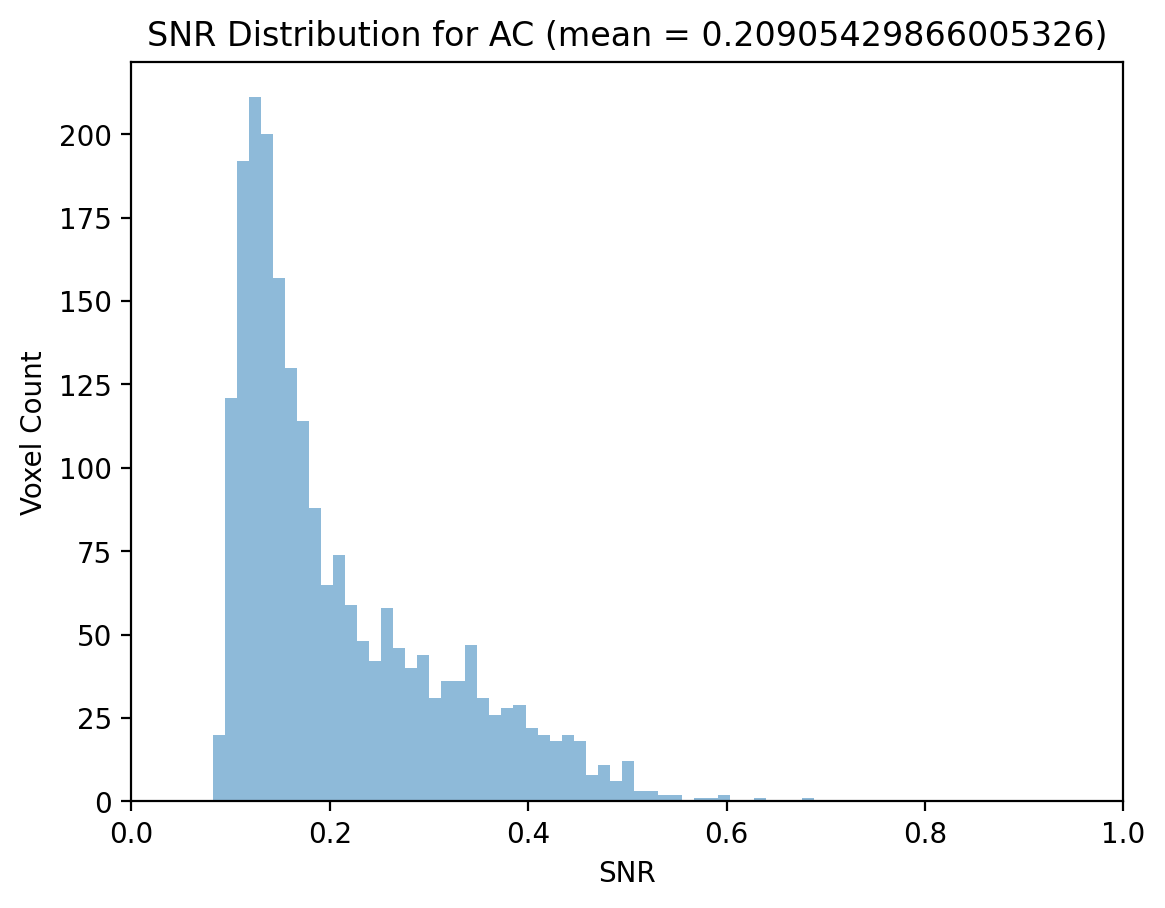

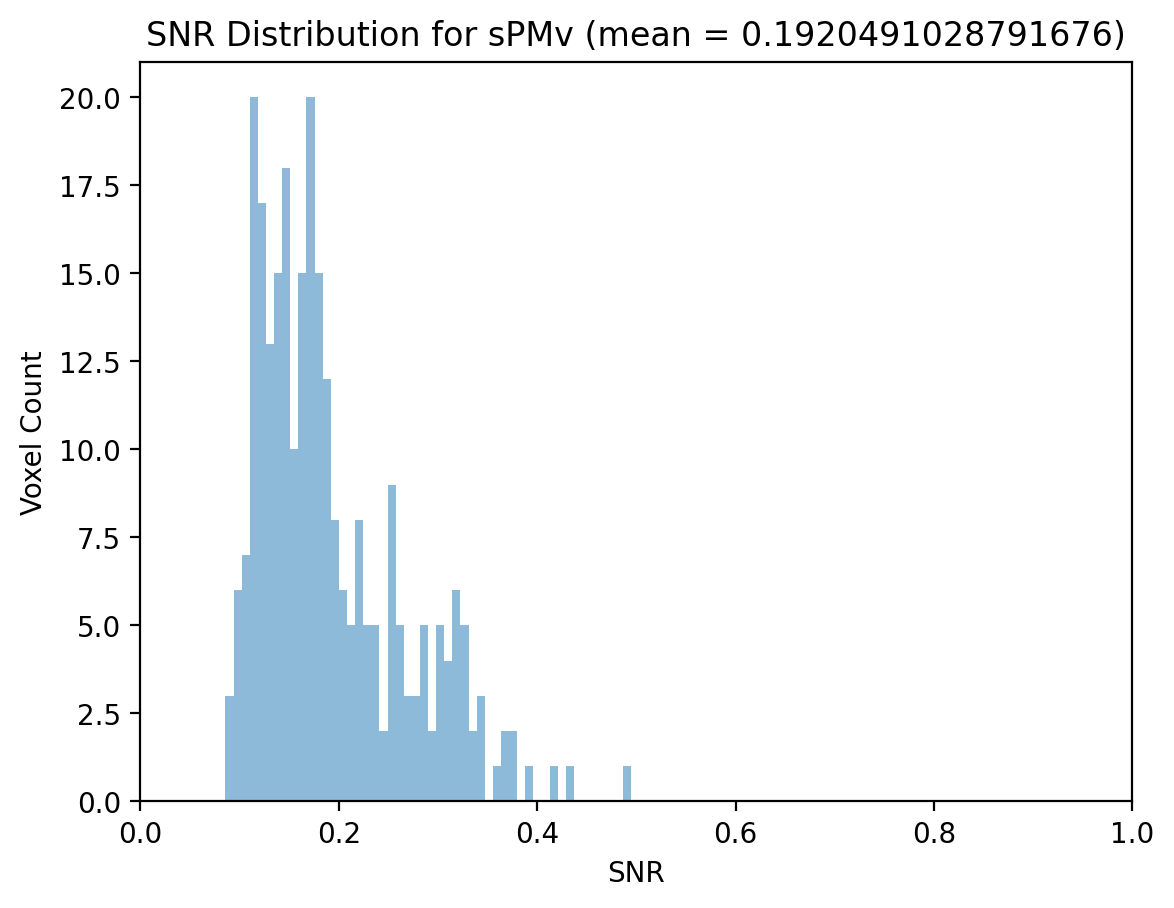

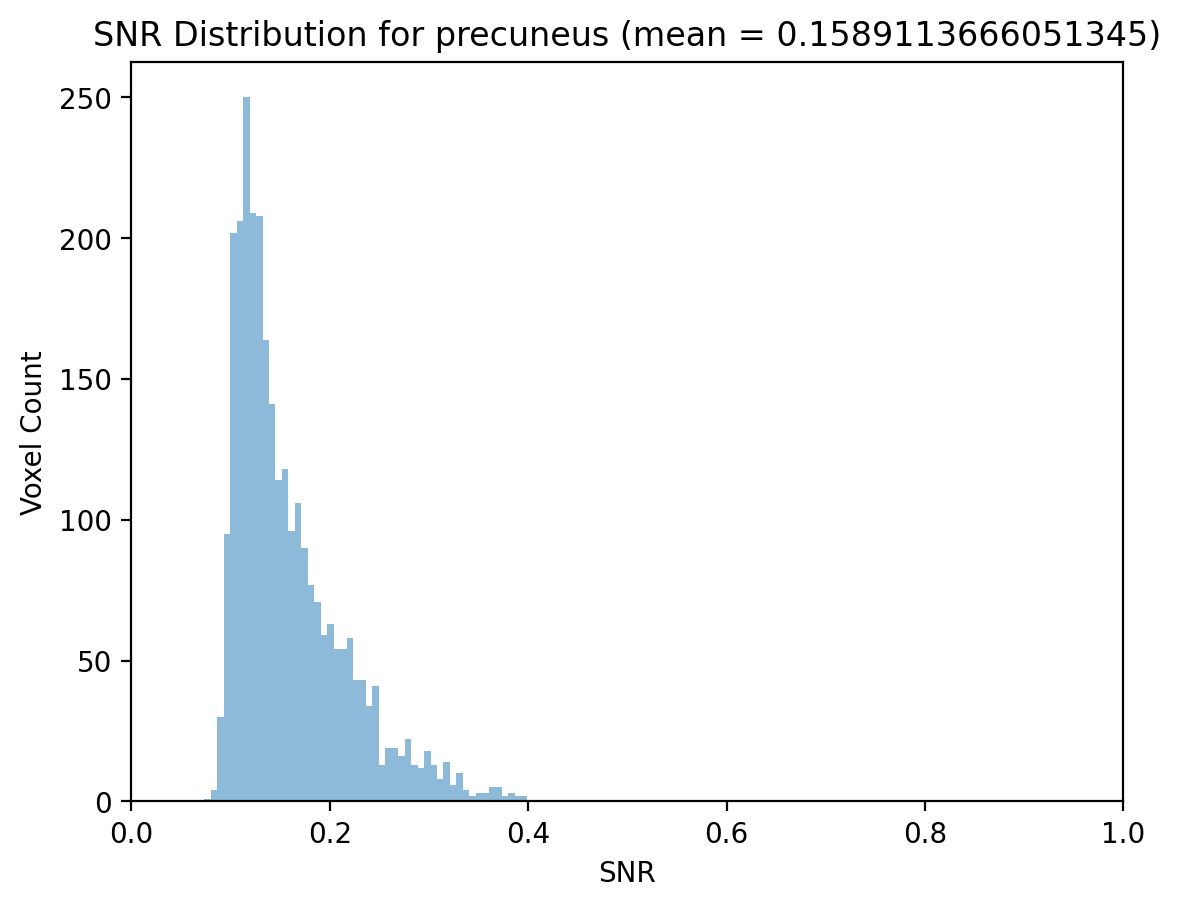

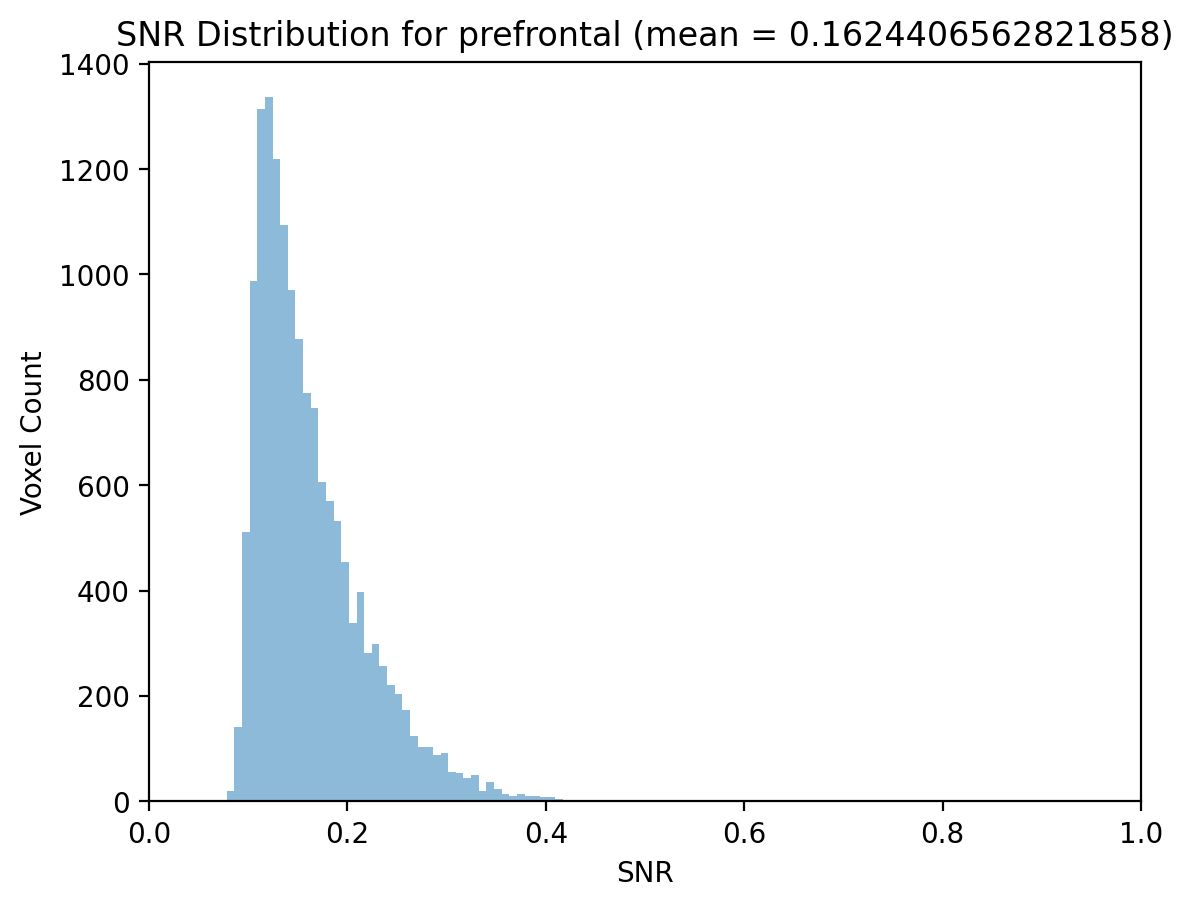

In [283]:
roi_snrs = {}
for roi in roi_voxs:
    roi_snrs[roi] = []
    for roi_idx in roi_voxs[roi]:
        snr = estimate_snr(response_trials[:,:,roi_idx])
        roi_snrs[roi].append(snr)

figs = []
for roi, snrs in roi_snrs.items():
    mean = np.mean(snrs)
    fig, ax = plt.subplots()
    ax.hist(snrs, bins=50, edgecolor='none', alpha=0.5)
    ax.set_title(f"SNR Distribution for {roi} (mean = {mean})")
    ax.set_xlim([0,1])
    ax.set_xlabel("SNR")
    ax.set_ylabel("Voxel Count")
    figs.append(fig)

plt.show()
    

In [288]:
# bin voxels based on SNRs
snr_bin_edges = np.arange(0.1,0.4,0.1)
bin_ids = {}
roi_bins = {}
for roi, snrs in roi_snrs.items():
    bin_ids[roi] = np.digitize(snrs, snr_bin_edges)
    roi_bins[roi] = {}
    for bin_id in np.unique(bin_ids[roi]):
        bin_voxels = [idx for idx, b in zip(roi_voxs[roi], bin_ids[roi]) if b == bin_id]
        roi_bins[roi][bin_id] = bin_voxels

est_alpha_snr = {}
for roi, bins in roi_bins.items():
    est_alpha_snr[roi] = {}
    for bin_id in bins:
        vox_idx_list = bins[bin_id]
        if len(vox_idx_list) == 0:
            continue
        binned_response = response_trials[:,:,vox_idx_list]
        zs_avg_resp = zs(np.mean(binned_response,axis=(0,2)))
        ar1_model = sm.tsa.AutoReg(zs_avg_resp, lags = 1).fit()
        est_alpha_snr[roi][bin_id] = ar1_model.params[1]

In [301]:
# Define bin edges again to map bin IDs to readable ranges
snr_bin_edges = np.arange(0.1, 0.4, 0.1)

# Print in desired format: ROI: snr bin (edge range): alpha
for roi, bins in est_alpha_snr.items():
    for bin_id, alpha in sorted(bins.items()):
        if bin_id ==0 or bin_id >= 4:
            continue
        if bin_id <= len(snr_bin_edges) - 1:
            bin_start = snr_bin_edges[bin_id - 1]
            bin_end = snr_bin_edges[bin_id]
            print(f"{roi}: SNR Bin {bin_id} ({bin_start:.1f}–{bin_end:.1f}): alpha = {alpha:.4f}")
        else:
            print(f"{roi}: SNR Bin {bin_id} (> {snr_bin_edges[-1]:.1f}): alpha = {alpha:.4f}")


AC: SNR Bin 1 (0.1–0.2): alpha = 0.7219
AC: SNR Bin 2 (0.2–0.3): alpha = 0.7038
AC: SNR Bin 3 (0.3–0.4): alpha = 0.7322
sPMv: SNR Bin 1 (0.1–0.2): alpha = 0.7471
sPMv: SNR Bin 2 (0.2–0.3): alpha = 0.7550
sPMv: SNR Bin 3 (0.3–0.4): alpha = 0.7500
precuneus: SNR Bin 1 (0.1–0.2): alpha = 0.8383
precuneus: SNR Bin 2 (0.2–0.3): alpha = 0.8654
precuneus: SNR Bin 3 (0.3–0.4): alpha = 0.8833
prefrontal: SNR Bin 1 (0.1–0.2): alpha = 0.8880
prefrontal: SNR Bin 2 (0.2–0.3): alpha = 0.8555
prefrontal: SNR Bin 3 (0.3–0.4): alpha = 0.8482
